In [1]:
import sys
import os
import csv
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap.umap_ as umap
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
import scipy.stats as stats
from matplotlib import patches as mpatches
from itertools import combinations
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import statsmodels.stats.multitest as multi;
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler


In [2]:
#data cleaning steps for gtex and tcga
def gtex_data_processing(gtex_gct_dataset):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']
    gtex_breast_data_all=pd.read_csv(gtex_gct_dataset,sep='\t')
    gtex_breast_data_all=gtex_breast_data_all.T.copy()
    gtex_breast_data_all.columns=gtex_breast_data_all.iloc[2]
    df_int=gtex_breast_data_all.loc[(gtex_breast_data_all.index!='id')&(gtex_breast_data_all.index!='Name')&(gtex_breast_data_all.index!='Description')].astype('float').copy()
    #drop unwanted integrins    
    df_int=df_int.drop([undesired_integrin for undesired_integrin in df_int.columns if undesired_integrin in unwanted_integrins],axis=1)
    #drop duplicate gene names (if any) 
    df_int=df_int.loc[:,~df_int.columns.duplicated()]    
    return df_int
#below funciton specific to breast cancer BRCA dataset ONLY
def tcga_brca_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info):
    global tcga_brca_df, tcga_brca_sample_info
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    tcga_brca_df = pd.read_csv(tcga_hiseq_dataset, sep = '\t', index_col=0)
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    
    tcga_brca_sample_info = pd.read_csv(tcga_hiseq_corresponding_sample_info,sep="\t",index_col=0)
    #below line is to drop metastatic from main sample type df, but we are not doing that now
    #tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
    
    #drop males from sample info b/c this is breast cancer
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender=="FEMALE"]
    
    #to merge tcga_brca_df and tcga_brca_sample_info, calculate common samples between the two
    common_cols=tcga_brca_sample_info.index.intersection(tcga_brca_df.columns)
    #use the common_cols variable to make tcga_brca_df and tcga_brca_sample_info contain same # of samples
    tcga_brca_df = tcga_brca_df[common_cols]
    tcga_brca_sample_info = tcga_brca_sample_info.loc[common_cols]
    
    #separate normal and primtum
    tcga_brca_normal_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Solid Tissue Normal']
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']

    #drop index of samples not in tcga_brca_df
    tcga_brca_normal_patients=  tcga_brca_normal_patients.drop(non_match for non_match in tcga_brca_normal_patients.index.values if non_match not in tcga_brca_df.columns)
    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 

    #make sure both normal and tumor patients match, and drop patients not in tcga_brca_df
    matched_patient_index_list=[]
    for patient in tcga_brca_primtum_patients.patient_id.values:
        if patient in tcga_brca_normal_patients.patient_id.values and patient in [patient_id.split('-')[2] for patient_id in tcga_brca_df.columns]:
            matched_patient_index_list.append(tcga_brca_sample_info[tcga_brca_sample_info.patient_id==patient].index.values)
    matched_patient_list=tcga_brca_sample_info.loc[[x for l in matched_patient_index_list for x in l]].copy()


    #separate normal and primary tumor
    normal_matched_patient_list=matched_patient_list[matched_patient_list.sample_type=='Solid Tissue Normal']
    primtum_matched_patient_list = matched_patient_list[matched_patient_list.sample_type=='Primary Tumor']

    #matched normal and primary tumor samples
    tcga_brca_df_normal_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(normal_matched_patient_list.index.values)]]
    tcga_brca_df_primtum_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(primtum_matched_patient_list.index.values)]]

    #test to see if normal and primary tumor patient IDs are a match
    for i in [patient_id.split('-')[2] for patient_id in tcga_brca_df_normal_matched.columns]:
        if i not in [patient_id.split('-')[2] for patient_id in tcga_brca_df_primtum_matched.columns]:
            print('trouble')
            
    #TCGA brca normal ALL
    tcga_brca_df_normal_all = tcga_brca_df.T.loc[tcga_brca_normal_patients.index.values].copy()
    # dataframe with all TCGA primary tumor samples (not necessarily matched)
    tcga_brca_df_primtum_all= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_normal_matched':tcga_brca_df_normal_matched,
           'tcga_brca_df_primtum_matched':tcga_brca_df_primtum_matched,
           'tcga_brca_df_normal_all':tcga_brca_df_normal_all,
           'tcga_brca_df_primtum_all':tcga_brca_df_primtum_all}

In [3]:
#this is how i manually cleaned data (incomplete), tread cautiously
# brca_expr=pd.read_csv("/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.BRCA.sampleMap/HiSeqV2",sep='\t')
# brca_expr=brca_expr.set_index('sample')
# for col in brca_expr.columns:
#     brca_expr.columns=brca_expr.columns.str.replace(col,col.replace('.','-'))

# brca_clin=pd.read_csv("/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix",sep='\t')
# brca_clin=brca_clin.set_index('sampleID')
#dropping males
#brca_clin=brca_clin[brca_clin.gender=='FEMALE']



In [4]:
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.BRCA.sampleMap/HiSeqV2'
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix'

processed_tcga_brca = tcga_brca_data_processing(tcga_hiseq_dataset,tcga_hiseq_corresponding_sample_info)

tcga_brca_df_normal_all = processed_tcga_brca['tcga_brca_df_normal_all']
tcga_brca_df_primtum_all = processed_tcga_brca['tcga_brca_df_primtum_all']
tcga_brca_df_normal_matched = processed_tcga_brca['tcga_brca_df_normal_matched']
tcga_brca_df_primtum_matched = processed_tcga_brca['tcga_brca_df_primtum_matched']


In [5]:
for i in tcga_brca_sample_info.columns:
    print(i)

AJCC_Stage_nature2012
Age_at_Initial_Pathologic_Diagnosis_nature2012
CN_Clusters_nature2012
Converted_Stage_nature2012
Days_to_Date_of_Last_Contact_nature2012
Days_to_date_of_Death_nature2012
ER_Status_nature2012
Gender_nature2012
HER2_Final_Status_nature2012
Integrated_Clusters_no_exp__nature2012
Integrated_Clusters_unsup_exp__nature2012
Integrated_Clusters_with_PAM50__nature2012
Metastasis_Coded_nature2012
Metastasis_nature2012
Node_Coded_nature2012
Node_nature2012
OS_Time_nature2012
OS_event_nature2012
PAM50Call_RNAseq
PAM50_mRNA_nature2012
PR_Status_nature2012
RPPA_Clusters_nature2012
SigClust_Intrinsic_mRNA_nature2012
SigClust_Unsupervised_mRNA_nature2012
Survival_Data_Form_nature2012
Tumor_T1_Coded_nature2012
Tumor_nature2012
Vital_Status_nature2012
_INTEGRATION
_PANCAN_CNA_PANCAN_K8
_PANCAN_Cluster_Cluster_PANCAN
_PANCAN_DNAMethyl_BRCA
_PANCAN_DNAMethyl_PANCAN
_PANCAN_RPPA_PANCAN_K8
_PANCAN_UNC_RNAseq_PANCAN_K16
_PANCAN_miRNA_PANCAN
_PANCAN_mirna_BRCA
_PANCAN_mutation_PANCAN
_PA

In [6]:
tcga_brca_sample_info['ER_HER2_PR_combined_status']=[str(er)+'_'+str(her2)+'_'+str(pr) for er,her2,pr in zip(tcga_brca_sample_info['ER_Status_nature2012'],
                                                                                     tcga_brca_sample_info['HER2_Final_Status_nature2012'],
                                                                                     tcga_brca_sample_info['PR_Status_nature2012'])]


#based on this link:
#https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/breast-cancer-hormone-receptor-status.html#:~:text=What%20are%20estrogen%20and%20progesterone,for%20the%20cells%20to%20grow.
horm_recep_status=[]
for er,her2,pr in zip(tcga_brca_sample_info['ER_Status_nature2012'].values,
                     tcga_brca_sample_info['HER2_Final_Status_nature2012'].values,
                     tcga_brca_sample_info['PR_Status_nature2012'].values):
    if er=='Positive' and her2=='Positive' and pr=='Positive':
        horm_recep_status.append('triple_positive')
    elif er=='Negative' and her2=='Negative' and pr=='Negative':
        horm_recep_status.append('triple_negative')
    elif er=='Negative' and her2=='Negative' and pr=='Positive':
        horm_recep_status.append('receptor_negative')
    elif er=='Positive' and her2=='Negative' and pr=='Positive':
        horm_recep_status.append('receptor_positive')
    elif er=='Negative' and her2=='Positive' and pr=='Positive':
        horm_recep_status.append('receptor_positive')
    elif er=='Positive' and her2=='Positive' and pr=='Negative':
        horm_recep_status.append('receptor_positive')
    elif er=='Positive' and her2=='Negative' and pr=='Negative':
        horm_recep_status.append('receptor_positive')
    elif er=='Negative' and her2=='Positive' and pr=='Negative':
        horm_recep_status.append('receptor_positive')
    else:
        horm_recep_status.append('nan')
        
tcga_brca_sample_info['horm_recep_status']=horm_recep_status





In [7]:
tcga_brca_sample_info['ER_HER2_PR_combined_status'].value_counts()

Positive_Negative_Positive         417
nan_nan_nan                        400
Negative_Negative_Negative         123
Positive_Negative_Negative          61
Positive_Positive_Positive          55
Negative_Positive_Negative          30
nan_Negative_nan                    29
Positive_nan_Positive               21
Positive_Positive_Negative          18
Negative_Negative_Positive          12
Negative_nan_Negative               10
Positive_nan_Negative                6
Positive_Equivocal_Positive          6
Positive_Negative_Indeterminate      3
Positive_Equivocal_Negative          3
nan_Positive_nan                     2
Indeterminate_Positive_Negative      1
Negative_Negative_Indeterminate      1
Negative_Positive_Positive           1
Indeterminate_Positive_Positive      1
Negative_Negative_nan                1
Negative_Equivocal_Negative          1
Name: ER_HER2_PR_combined_status, dtype: int64

In [8]:
tcga_brca_sample_info['PAM50Call_RNAseq'].value_counts()

LumA      428
LumB      189
Basal     141
Normal    118
Her2       67
Name: PAM50Call_RNAseq, dtype: int64

In [9]:
tcga_brca_sample_info['pathologic_M'].value_counts()

M0          1003
MX           169
M1            23
cM0 (i+)       7
Name: pathologic_M, dtype: int64

# t-sne trials

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



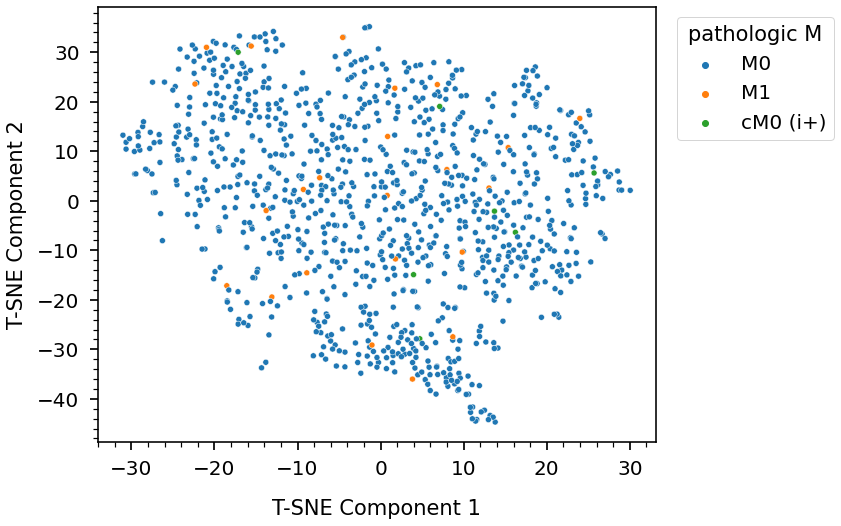

In [61]:
#drop MX from pathologic_M
#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[~(tcga_brca_sample_info['pathologic_M']=='MX')].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['pathologic_M']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'pathologic M', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df


In [53]:
tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal') & (tcga_brca_sample_info['PAM50Call_RNAseq'].notna())]['PAM50Call_RNAseq'].value_counts()


LumA     417
LumB     189
Basal    141
Her2      67
Name: PAM50Call_RNAseq, dtype: int64

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



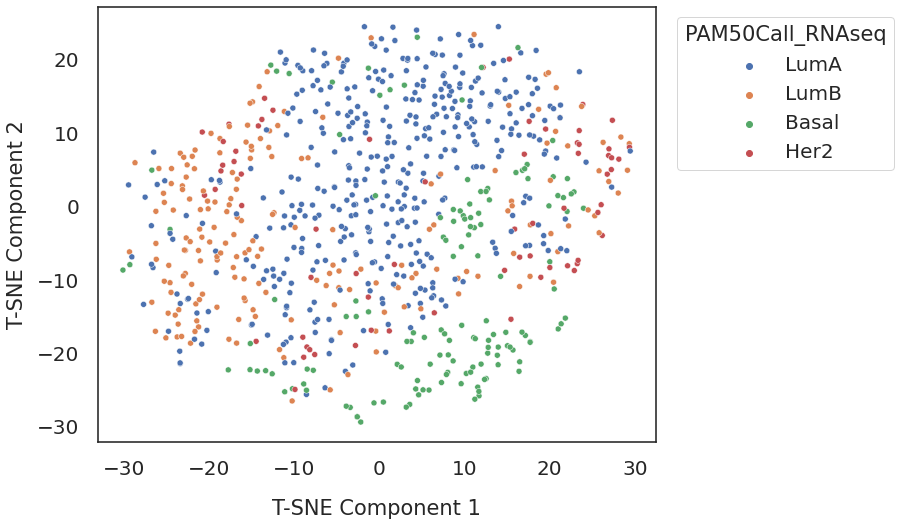

In [114]:

#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal') & (tcga_brca_sample_info['PAM50Call_RNAseq'].notna())].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['PAM50Call_RNAseq']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'PAM50Call_RNAseq', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



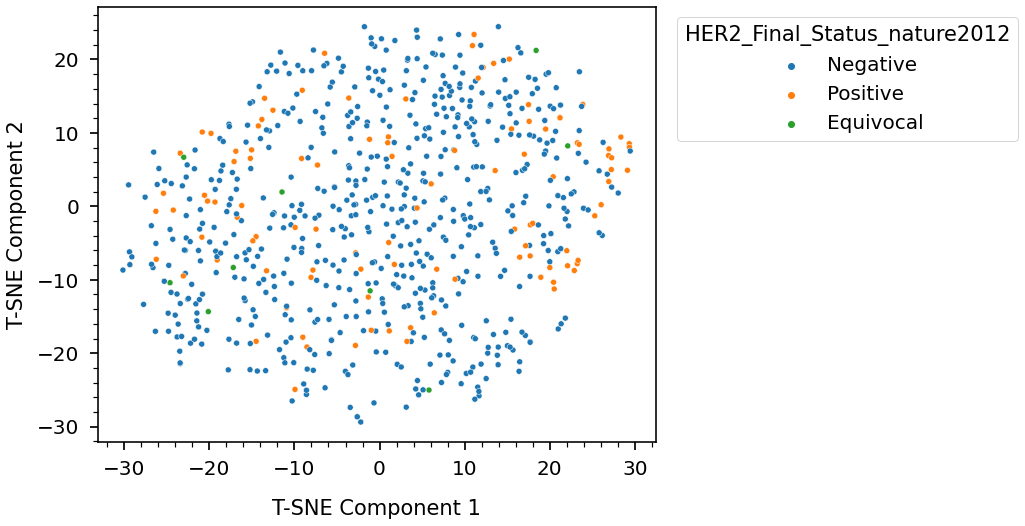

In [22]:

#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal') & (tcga_brca_sample_info['PAM50Call_RNAseq'].notna())].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['HER2_Final_Status_nature2012']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'HER2_Final_Status_nature2012', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



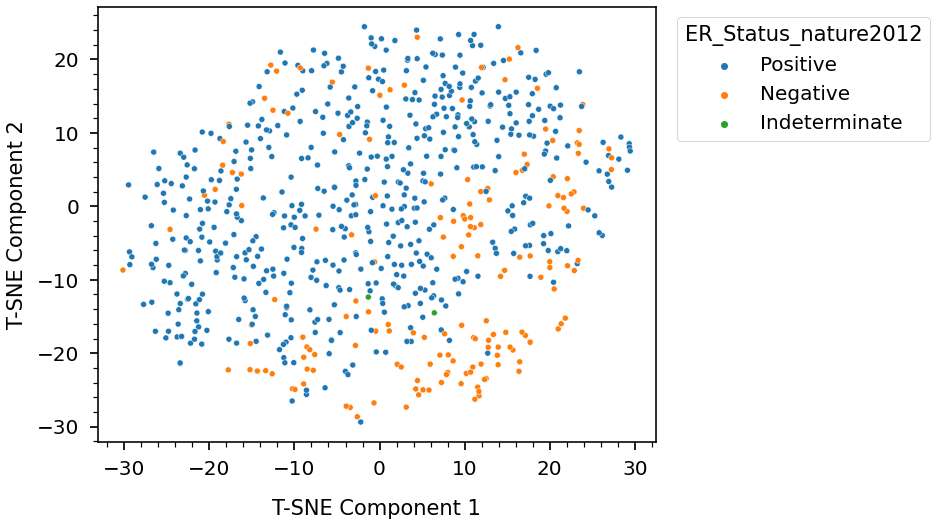

In [23]:

#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal') & (tcga_brca_sample_info['PAM50Call_RNAseq'].notna())].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['ER_Status_nature2012']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'ER_Status_nature2012', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



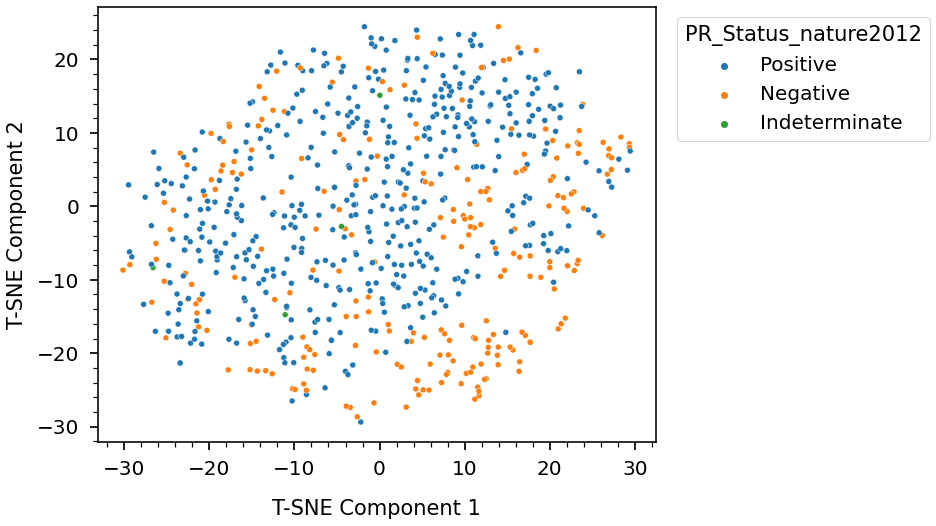

In [24]:

#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal') & (tcga_brca_sample_info['PAM50Call_RNAseq'].notna())].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['PR_Status_nature2012']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'PR_Status_nature2012', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df


In [48]:
tcga_brca_sample_info[(tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Indeterminate' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'nan' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Equivocal' not in x))]['ER_HER2_PR_combined_status'].value_counts()


Positive_Negative_Positive    417
Negative_Negative_Negative    123
Positive_Negative_Negative     61
Positive_Positive_Positive     55
Negative_Positive_Negative     30
Positive_Positive_Negative     18
Negative_Negative_Positive     12
Negative_Positive_Positive      1
Name: ER_HER2_PR_combined_status, dtype: int64

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



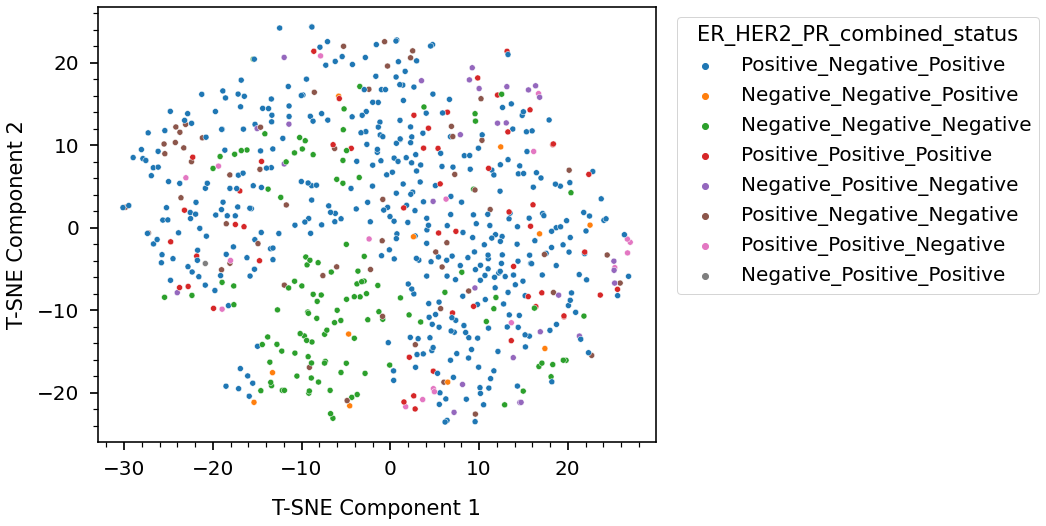

In [49]:


#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal')&(tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Indeterminate' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'nan' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Equivocal' not in x)) ].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['ER_HER2_PR_combined_status']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'ER_HER2_PR_combined_status', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df



In [52]:
tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal')&(tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Indeterminate' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'nan' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Equivocal' not in x)) ]['horm_recep_status'].value_counts()

receptor_positive    514
triple_negative      120
triple_positive       54
receptor_negative     11
Name: horm_recep_status, dtype: int64

/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



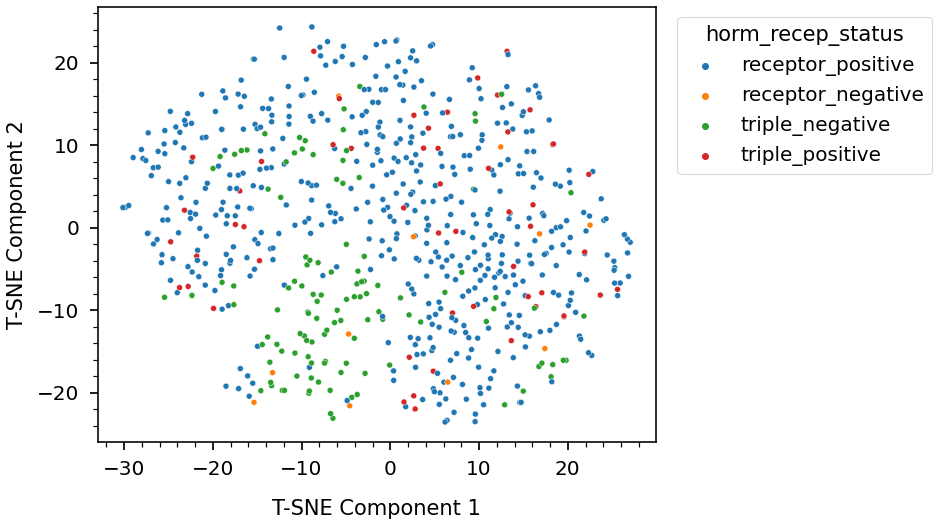

In [51]:


#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal')&(tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Indeterminate' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'nan' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Equivocal' not in x)) ].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['horm_recep_status']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'horm_recep_status', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df



In [ ]:


#using only integrins
#be careful with temp_samples
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal')&(tcga_brca_sample_info["ER_HER2_PR_combined_status"]=='Positive_Negative_Positive')].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['ER_HER2_PR_combined_status']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'ER_HER2_PR_combined_status', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df



/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



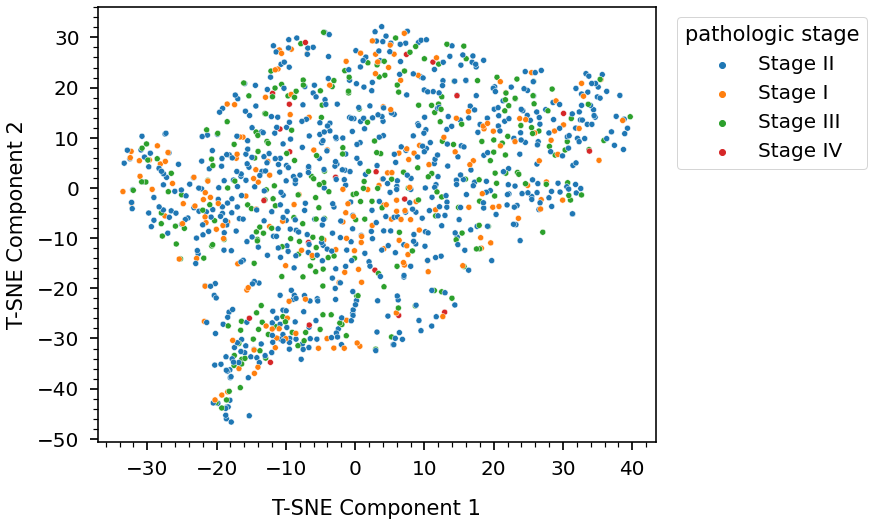

In [86]:
#drop discrepancy, stage X, and equalize the samples
#using only integrins
temp_info_sample = tcga_brca_sample_info[~(tcga_brca_sample_info.pathologic_stage.isin(['[Discrepancy]','Stage X']))].copy()
temp_tcga_brca_df = tcga_brca_df[temp_info_sample.index].copy()
#create a new column, where the stages are simpler
temp_info_sample['simple_stage']=temp_info_sample['pathologic_stage'].map({'Stage IIA': 'Stage II',
                                          'Stage IIB': 'Stage II',
                                         'Stage IIIA': 'Stage III',
                                         'Stage IIIB': 'Stage III',
                                         'Stage IIIC': 'Stage III',
                                         'Stage IA': 'Stage I',
                                         'Stage IB': 'Stage I',
                                         'Stage I': 'Stage I',
                                         'Stage II': 'Stage II',
                                         'Stage III': 'Stage III',
                                         'Stage IV': 'Stage IV'})

#make a separate column for stage


fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = temp_info_sample.loc[data.index]['simple_stage']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'pathologic stage', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_info_sample, temp_tcga_brca_df


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



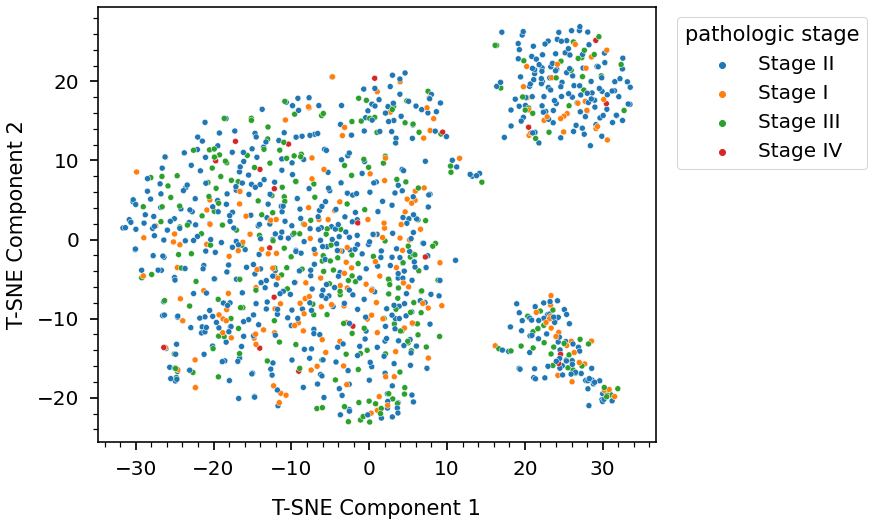

In [91]:
#drop discrepancy, stage X, and equalize the samples
#using ALL genes
temp_info_sample = tcga_brca_sample_info[~(tcga_brca_sample_info.pathologic_stage.isin(['[Discrepancy]','Stage X']))].copy()
temp_tcga_brca_df = tcga_brca_df[temp_info_sample.index].copy()
#create a new column, where the stages are simpler
temp_info_sample['simple_stage']=temp_info_sample['pathologic_stage'].map({'Stage IIA': 'Stage II',
                                          'Stage IIB': 'Stage II',
                                         'Stage IIIA': 'Stage III',
                                         'Stage IIIB': 'Stage III',
                                         'Stage IIIC': 'Stage III',
                                         'Stage IA': 'Stage I',
                                         'Stage IB': 'Stage I',
                                         'Stage I': 'Stage I',
                                         'Stage II': 'Stage II',
                                         'Stage III': 'Stage III',
                                         'Stage IV': 'Stage IV'})

#make a separate column for stage


fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_tcga_brca_df.T
feat = temp_info_sample.loc[data.index]['simple_stage']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'pathologic stage', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_info_sample, temp_tcga_brca_df


/home/hshadman/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



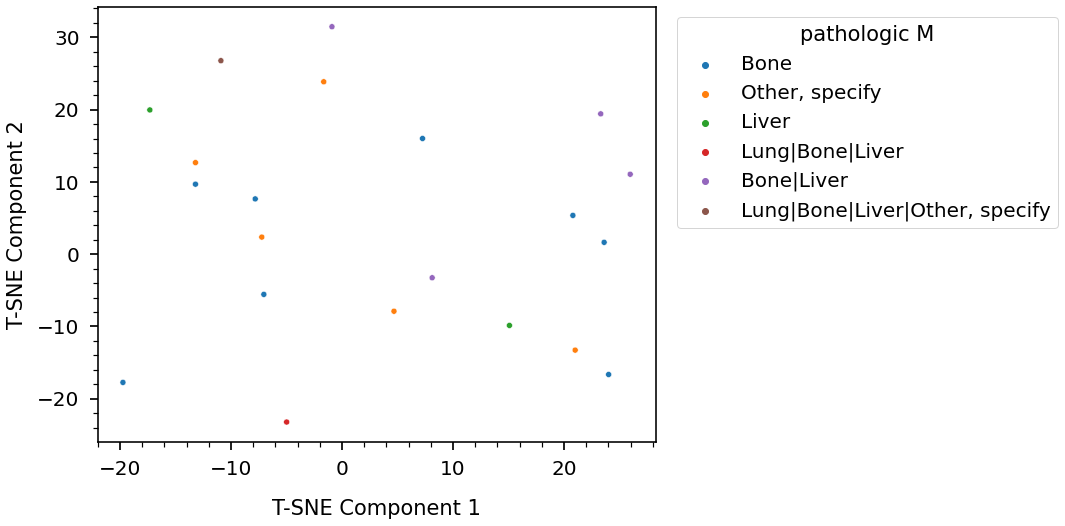

In [111]:
#dropping MX and dropping normal solid tissue samples
#using only integrin expression
temp_samples=tcga_brca_sample_info[~(tcga_brca_sample_info['pathologic_M']=='MX')]
temp_samples = temp_samples[temp_samples.sample_type!='Solid Tissue Normal']
temp_tcga_brca_df = tcga_brca_df[temp_samples.index].copy()


fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_samples
data = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
feat = tcga_brca_sample_info.loc[temp_samples.index].loc[data.index]['metastatic_site_at_diagnosis']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'pathologic M', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()
del temp_samples, temp_tcga_brca_df


In [109]:
temp_samples=tcga_brca_sample_info[~(tcga_brca_sample_info['pathologic_M']=='MX')]
temp_samples = temp_samples[temp_samples.sample_type!='Solid Tissue Normal']
temp_tcga_brca_df = tcga_brca_df[temp_samples.index].copy()
temp_samples['metastatic_site_at_diagnosis'].value_counts()


Bone                              8
Other, specify                    5
Bone|Liver                        4
Liver                             2
Lung|Bone|Liver|Other, specify    1
Lung|Bone|Liver                   1
Name: metastatic_site_at_diagnosis, dtype: int64

In [110]:
temp_samples.columns[temp_samples.columns.str.contains('metast')]

Index(['additional_surgery_metastatic_procedure',
       'days_to_additional_surgery_metastatic_procedure',
       'distant_metastasis_present_ind2',
       'her2_neu_metastatic_breast_carcinoma_copy_analysis_inpt_ttl_nmbr',
       'metastatic_breast_carcinm_ps_fndng_prgstrn_rcptr_thr_msr_scl_txt',
       'metastatic_breast_carcinom_lb_prc_hr2_n_mmnhstchmstry_rcptr_stts',
       'metastatic_breast_carcinoma_erbb2_immunohistochemistry_levl_rslt',
       'metastatic_breast_carcinoma_estrogen_receptor_detection_mthd_txt',
       'metastatic_breast_carcinoma_estrogen_receptor_status',
       'metastatic_breast_carcinoma_estrogen_receptr_lvl_cll_prcnt_ctgry',
       'metastatic_breast_carcinoma_her2_erbb_method_calculatin_mthd_txt',
       'metastatic_breast_carcinoma_her2_erbb_pos_findng_cll_prcnt_ctgry',
       'metastatic_breast_carcinoma_her2_neu_chromosone_17_signal_rat_vl',
       'metastatic_breast_carcinoma_immunhstchmstry_r_pstv_fndng_scl_typ',
       'metastatic_breast_carcinoma_i

# t test (careful about order)

In [10]:
itg_list=tcga_brca_df.loc[tcga_brca_df.index.str.contains('ITG')].index

In [11]:
tcga_brca_df_normal_matched

,TCGA-A7-A0CE-11,TCGA-A7-A0CH-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,...,TCGA-E9-A1NG-11,TCGA-E9-A1R7-11,TCGA-E9-A1RB-11,TCGA-E9-A1RC-11,TCGA-E9-A1RD-11,TCGA-E9-A1RF-11,TCGA-E9-A1RH-11,TCGA-E9-A1RI-11,TCGA-GI-A2C8-11,TCGA-GI-A2C9-11
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.9980,10.0819,9.5692,9.9530,10.0876,9.6265,10.3847,8.5990,9.5065,9.9090,...,10.1785,9.5149,9.4134,9.5920,9.8345,9.1559,9.4519,8.5599,11.4655,10.1605
HIF3A,6.1594,8.5517,9.3537,8.4743,8.4513,8.1546,8.2842,10.0837,8.6655,8.1872,...,7.8284,9.1886,7.8353,9.1444,8.4490,9.3591,9.1667,9.6765,7.1927,8.0760
RNF17,4.1813,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.8553,0.0000,1.4583,0.6975,1.3813,3.4103,0.0000,2.2077,2.6801
RNF10,11.7961,11.9788,11.9178,11.8456,11.7447,11.9869,11.7907,11.8645,11.6472,11.8263,...,11.8528,11.8201,11.8439,12.0187,11.8588,11.9110,11.8981,12.1180,13.3639,11.4906
RNF11,11.2214,11.5315,11.9225,11.5743,11.8232,11.9344,11.5187,12.2617,11.6499,11.5754,...,11.9259,12.2380,11.9400,12.2147,11.9001,12.2798,12.1746,13.0778,12.3311,11.5022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRF,13.7843,15.1120,15.6531,14.8932,14.4577,14.3703,14.3798,14.2898,13.9341,14.5242,...,15.3876,15.1685,14.4133,15.4023,15.1075,14.8809,14.7675,14.8309,13.0824,14.2220
BCL6B,8.0209,9.0868,9.4835,9.6457,8.3374,9.7785,9.6968,9.3801,8.9867,9.1906,...,9.3100,9.3268,8.1669,9.7527,9.5528,10.0796,9.1603,9.9381,9.1009,9.7099
GSTK1,11.8650,11.7615,11.3607,11.1019,11.0739,11.6932,11.4580,11.4126,11.1600,11.4123,...,11.2147,11.0763,10.9630,11.6692,11.4545,11.4236,11.3393,11.2866,11.5277,11.1542


In [12]:
tcga_brca_df_primtum_matched

,TCGA-A7-A0CE-01,TCGA-A7-A0CH-01,TCGA-A7-A0D9-01,TCGA-A7-A0DB-01,TCGA-A7-A0DC-01,TCGA-A7-A13E-01,TCGA-A7-A13F-01,TCGA-A7-A13G-01,TCGA-AC-A23H-01,TCGA-AC-A2FB-01,...,TCGA-E9-A1NG-01,TCGA-E9-A1R7-01,TCGA-E9-A1RB-01,TCGA-E9-A1RC-01,TCGA-E9-A1RD-01,TCGA-E9-A1RF-01,TCGA-E9-A1RH-01,TCGA-E9-A1RI-01,TCGA-GI-A2C8-01,TCGA-GI-A2C9-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.5751,9.3815,10.9025,9.4012,10.4153,10.7570,8.5945,10.3220,8.8195,9.9276,...,9.4294,9.6908,9.2397,8.8962,9.4848,9.3493,8.2308,9.2448,9.5326,10.5932
HIF3A,4.1385,1.2069,2.8431,3.9239,2.1237,3.0461,1.3821,1.5278,0.3758,4.6244,...,0.9362,3.1278,2.7491,2.4500,2.0312,0.4236,4.3911,2.0755,2.1199,4.4620
RNF17,1.4303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3571,0.0000,0.0000,0.7380
RNF10,11.4626,11.9762,11.7959,11.9896,12.2180,11.1565,12.1455,12.2527,11.7630,11.8653,...,11.9238,11.6685,12.3296,12.1158,12.0729,12.5901,11.4418,11.9627,11.6077,11.1465
RNF11,10.5215,11.5613,11.1640,11.4222,10.7349,10.7619,11.2860,11.3740,11.4354,11.3595,...,11.5936,12.5210,11.2235,10.7523,11.3306,10.8420,11.0743,11.4729,10.7229,11.5265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRF,12.0442,11.5334,11.9928,12.5592,9.5841,12.3077,12.1541,11.0816,11.7673,12.1154,...,13.9218,10.8813,11.5790,11.3956,11.1910,12.3704,12.6019,12.5837,12.6460,12.8037
BCL6B,7.9431,7.4656,7.8449,7.8173,7.7441,7.5614,8.4345,7.4717,7.7196,8.3494,...,9.2699,7.2374,7.1095,7.5977,8.6300,8.2709,6.3777,8.1045,9.0959,6.3892
GSTK1,12.0940,11.2451,12.1377,11.5188,10.3086,11.4325,12.0005,9.9272,10.2207,11.1862,...,10.4849,10.6271,10.6390,9.4963,11.1813,11.9763,10.1158,10.8587,13.1707,11.4231


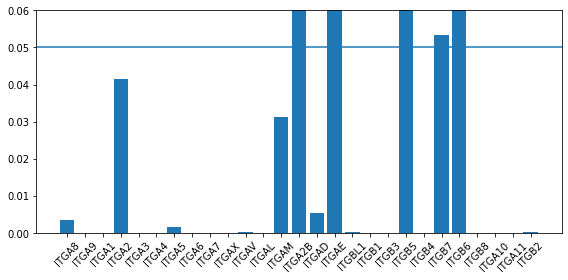

In [13]:
sig_itg=[]

for integrin in itg_list:
    data_group1=tcga_brca_df_normal_matched.loc[integrin].values
    data_group2=tcga_brca_df_primtum_matched.loc[integrin].values
    sig_itg.append([integrin,stats.ttest_rel(a=data_group1, b=data_group2).pvalue])
fig,ax=plt.subplots(figsize=(8,4))
ax.bar([itg[0] for itg in sig_itg],[itg[1] for itg in sig_itg])
plt.setp(ax.get_xticklabels(),rotation=45)
ax.axhline(y=0.05)
ax.set_ylim(0,0.06)
plt.tight_layout()    


In [14]:
#combine matched primary tumor and normal tissue sample into single df
temp_tcga_brca_df_normal_matched=tcga_brca_df_normal_matched.copy()
temp_tcga_brca_df_normal_matched.loc['sample_type']=np.repeat('normal',temp_tcga_brca_df_normal_matched.shape[1])
temp_tcga_brca_df_primtum_matched=tcga_brca_df_primtum_matched.copy()
temp_tcga_brca_df_primtum_matched.loc['sample_type']=np.repeat('primary_tumor',temp_tcga_brca_df_primtum_matched.shape[1])
temp_tcga_brca_df_matched_samples = pd.concat([temp_tcga_brca_df_normal_matched,temp_tcga_brca_df_primtum_matched],axis=1)
del temp_tcga_brca_df_normal_matched, temp_tcga_brca_df_primtum_matched
temp_tcga_brca_df_matched_samples


,TCGA-A7-A0CE-11,TCGA-A7-A0CH-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,...,TCGA-E9-A1NG-01,TCGA-E9-A1R7-01,TCGA-E9-A1RB-01,TCGA-E9-A1RC-01,TCGA-E9-A1RD-01,TCGA-E9-A1RF-01,TCGA-E9-A1RH-01,TCGA-E9-A1RI-01,TCGA-GI-A2C8-01,TCGA-GI-A2C9-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.998,10.0819,9.5692,9.953,10.0876,9.6265,10.3847,8.599,9.5065,9.909,...,9.4294,9.6908,9.2397,8.8962,9.4848,9.3493,8.2308,9.2448,9.5326,10.5932
HIF3A,6.1594,8.5517,9.3537,8.4743,8.4513,8.1546,8.2842,10.0837,8.6655,8.1872,...,0.9362,3.1278,2.7491,2.45,2.0312,0.4236,4.3911,2.0755,2.1199,4.462
RNF17,4.1813,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2.3571,0,0,0.738
RNF10,11.7961,11.9788,11.9178,11.8456,11.7447,11.9869,11.7907,11.8645,11.6472,11.8263,...,11.9238,11.6685,12.3296,12.1158,12.0729,12.5901,11.4418,11.9627,11.6077,11.1465
RNF11,11.2214,11.5315,11.9225,11.5743,11.8232,11.9344,11.5187,12.2617,11.6499,11.5754,...,11.5936,12.521,11.2235,10.7523,11.3306,10.842,11.0743,11.4729,10.7229,11.5265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCL6B,8.0209,9.0868,9.4835,9.6457,8.3374,9.7785,9.6968,9.3801,8.9867,9.1906,...,9.2699,7.2374,7.1095,7.5977,8.63,8.2709,6.3777,8.1045,9.0959,6.3892
GSTK1,11.865,11.7615,11.3607,11.1019,11.0739,11.6932,11.458,11.4126,11.16,11.4123,...,10.4849,10.6271,10.639,9.4963,11.1813,11.9763,10.1158,10.8587,13.1707,11.4231
SELP,9.4408,9.6457,9.5624,9.8665,9.1781,9.9759,9.2115,9.6731,8.9703,9.7228,...,2.8865,6.4695,3.9605,3.1597,4.6691,5.8832,0.3975,4.5549,6.5293,2.5047


In [15]:
itg_expr_dict={'integrin':[],'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_tcga_brca_df_matched_samples.loc[temp_tcga_brca_df_matched_samples.index.str.contains('ITG')].index:
    itg_expr_dict['integrin'].append(itg)
    normal_sample_expr=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='normal'].loc[itg].mean()
    primtum_sample_expr=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='primary_tumor'].loc[itg].mean()
    if primtum_sample_expr>normal_sample_expr:
        itg_expr_dict['relative_expression'].append('high')
    elif primtum_sample_expr<normal_sample_expr:
        itg_expr_dict['relative_expression'].append('low')
    else:
        itg_expr_dict['relative_expression'].append('same_double_check')
    p_value_itg=stats.ttest_rel(a=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='normal'].loc[itg],
                                                    b=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='primary_tumor'].loc[itg]).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
itg_expr_df['bar_color']=['red' if expr=='high' else 'blue' for expr in itg_expr_df['relative_expression'].values ]
itg_expr_df


,relative_expression,p_value,significant,bar_color
integrin,,,,
ITGA8,low,3.315562e-03,yes,blue
ITGA9,low,1.102679e-26,yes,blue
ITGA1,low,2.577708e-09,yes,blue
ITGA2,low,4.145910e-02,yes,blue
ITGA3,low,5.210551e-08,yes,blue
ITGA4,high,3.801670e-07,yes,red
ITGA5,high,1.640521e-03,yes,red
ITGA6,low,8.991371e-18,yes,blue
ITGA7,low,6.442589e-31,yes,blue


In [16]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying benjamin hochberg, calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bh']=multi.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bh']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bh'].values ]
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df


,relative_expression,p_value,significant,bar_color,adj_p_val_bh,adj_significant_bh,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,
ITGA8,low,3.315562e-03,yes,blue,4.711587e-03,yes,8.952016e-02,no
ITGA9,low,1.102679e-26,yes,blue,1.488617e-25,yes,2.977235e-25,yes
ITGA1,low,2.577708e-09,yes,blue,1.159969e-08,yes,6.959812e-08,yes
ITGA2,low,4.145910e-02,yes,blue,5.088163e-02,no,1.000000e+00,no
ITGA3,low,5.210551e-08,yes,blue,1.406849e-07,yes,1.406849e-06,yes
ITGA4,high,3.801670e-07,yes,red,8.553758e-07,yes,1.026451e-05,yes
ITGA5,high,1.640521e-03,yes,red,2.460782e-03,yes,4.429407e-02,yes
ITGA6,low,8.991371e-18,yes,blue,8.092234e-17,yes,2.427670e-16,yes
ITGA7,low,6.442589e-31,yes,blue,1.739499e-29,yes,1.739499e-29,yes


In [17]:
my_info=dict({'integrin':'ITGB2','expression':'high','p_value':0.04})
pd.DataFrame(my_info,index=[0]).set_index('integrin')

,expression,p_value
integrin,,
ITGB2,high,0.04


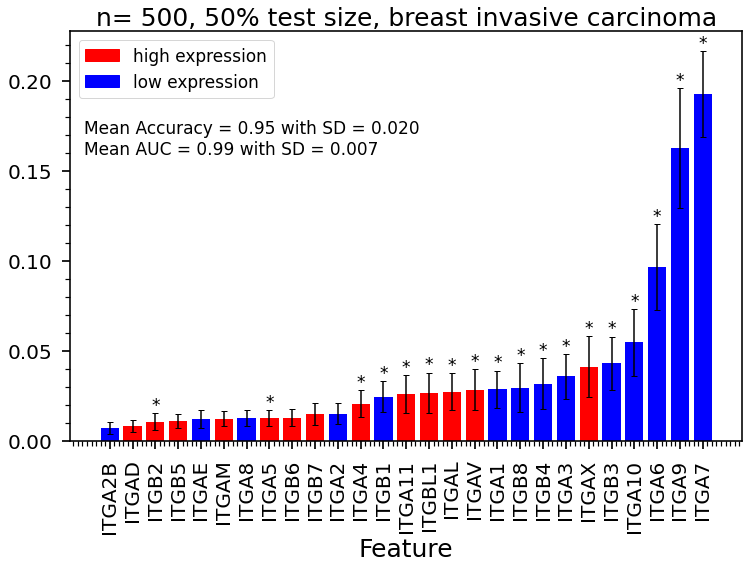

In [19]:

#class weight balanced here
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500
feature_importance=[]
accuracy=[]
test_size=0.50
auc_roc=[]
f1score=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_tcga_brca_df_matched_samples.loc[temp_tcga_brca_df_matched_samples.index[temp_tcga_brca_df_matched_samples.index.str.contains("ITG")]].T
    y = temp_tcga_brca_df_matched_samples.loc["sample_type"]
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    f1score.append(f1_score(y_test,y_pred,pos_label='primary_tumor'))
    auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3,
                                    color=feature_importance_df_mean.bar_color)
for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
    if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
        ax[1].annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
                   size=17, xytext=(0, 8),
                   textcoords='offset points')

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size, breast invasive carcinoma",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f'{i} expression' for i in colors]
plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
ax[1].text(0.02,
           0.7,
#f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}\nMean F1 score = {format(np.mean(np.array(f1score)),"0.2f")} with SD = {format(np.std(np.array(f1score)),"0.3f")}',
#           transform=ax[1].transAxes,fontsize=17)
           
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)
           

ax[0].remove()
plt.tight_layout()

plt.savefig('figures/mcbios_poster_figure_tcga_BRCA_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')


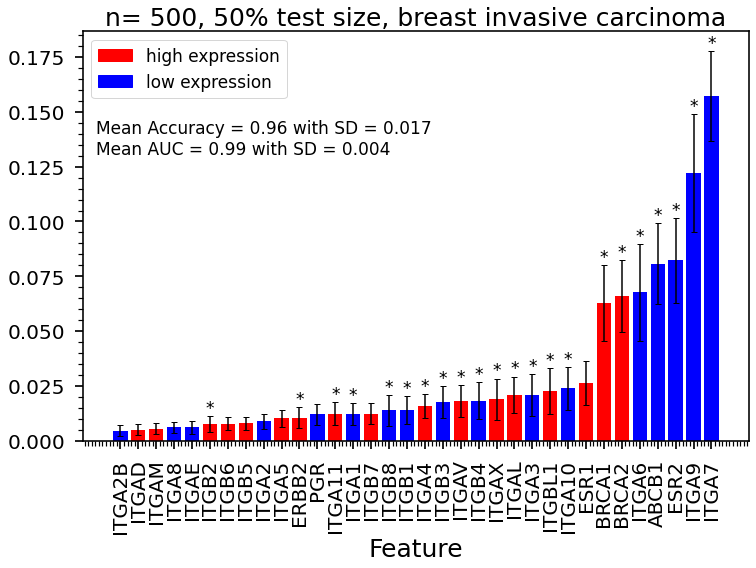

In [22]:
#including breast biomarkers with integrins
#also redoing multiple testing correction
breast_biomarker=["ESR1","BRCA1","BRCA2","ESR2","PGR","ABCB1","ERBB2"]

itg_expr_dict={'integrin':[],'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in list(temp_tcga_brca_df_matched_samples.loc[temp_tcga_brca_df_matched_samples.index.str.contains('ITG')].index)+breast_biomarker:
    itg_expr_dict['integrin'].append(itg)
    normal_sample_expr=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='normal'].loc[itg].mean()
    primtum_sample_expr=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='primary_tumor'].loc[itg].mean()
    if primtum_sample_expr>normal_sample_expr:
        itg_expr_dict['relative_expression'].append('high')
    elif primtum_sample_expr<normal_sample_expr:
        itg_expr_dict['relative_expression'].append('low')
    else:
        itg_expr_dict['relative_expression'].append('same_double_check')
    p_value_itg=stats.ttest_rel(a=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='normal'].loc[itg],
                                                    b=temp_tcga_brca_df_matched_samples.loc[:,temp_tcga_brca_df_matched_samples.loc['sample_type']=='primary_tumor'].loc[itg]).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
itg_expr_df['bar_color']=['red' if expr=='high' else 'blue' for expr in itg_expr_df['relative_expression'].values ]

#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying benjamin hochberg, calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bh']=multi.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bh']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bh'].values ]
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

#class weight balanced here
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500
feature_importance=[]
accuracy=[]
test_size=0.50
auc_roc=[]
f1score=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_tcga_brca_df_matched_samples.loc[list(temp_tcga_brca_df_matched_samples.index[temp_tcga_brca_df_matched_samples.index.str.contains("ITG")]) + breast_biomarker].T
    y = temp_tcga_brca_df_matched_samples.loc["sample_type"]
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]))
    f1score.append(f1_score(y_test,y_pred,pos_label='primary_tumor'))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3,
                                    color=feature_importance_df_mean.bar_color)
for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
    if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
        ax[1].annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
                   size=17, xytext=(0, 8),
                   textcoords='offset points')


ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size, breast invasive carcinoma",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=11,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=11)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f'{i} expression' for i in colors]
plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
ax[1].text(0.02,
           0.7,
#f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}\nMean F1 score = {format(np.mean(np.array(f1score)),"0.2f")} with SD = {format(np.std(np.array(f1score)),"0.3f")}',
#           transform=ax[1].transAxes,fontsize=17)
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)
           

ax[0].remove()
plt.tight_layout()

plt.savefig('figures/mcbios_poster_figure_tcga_BRCA_rf_classifier_class-weight_bal_w_biomarker.jpg', dpi = 1000, bbox_inches='tight')


In [17]:
fig, axes = plt.subplots(nrows=len(data[(data['pathologic_stage'].notna())&(data['pathologic_stage']!='[Discrepancy]')&(data['pathologic_stage']!='Stage X')].pathologic_stage.unique()),ncols=1,figsize=(25,100))
j=0
for cancer_status in data[data['pathologic_stage'].notna()].pathologic_stage.unique():
    if cancer_status!= '[Discrepancy]' and cancer_status!='Stage X':
        sns.set(style="whitegrid")
        ax=sns.violinplot(data=data[data.pathologic_stage==cancer_status][integrins],
                       scale='width',
                     ax=axes[j])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,fontsize=20)
        ax.tick_params(axis='y', labelsize=20)      
        axes[j].set_ylim(-4,16)
        axes[j].set_title('Breast Cancer: '+str(cancer_status),fontsize=30)
        j+=1
    
plt.tight_layout()

NameError: name 'data' is not defined

<AxesSubplot:>

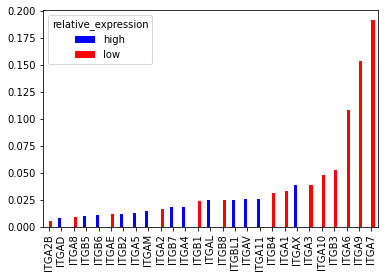

In [123]:
temp_impo=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1).copy()
#temp_impo = temp_impo.sort_values(by='importance')
temp_impo.pivot(columns='relative_expression',values='importance').loc[temp_impo.index].plot(kind='bar',color=temp_impo.bar_color.values)
#del temp_impo

# integrin expression between tumor and normal

In [21]:
itg_list

Index(['ITGA8', 'ITGA9', 'ITGA1', 'ITGA2', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6',
       'ITGA7', 'ITGAX', 'ITGAV', 'ITGAL', 'ITGAM', 'ITGA2B', 'ITGAD', 'ITGAE',
       'ITGBL1', 'ITGB1', 'ITGB3', 'ITGB5', 'ITGB4', 'ITGB7', 'ITGB6', 'ITGB8',
       'ITGA10', 'ITGA11', 'ITGB2'],
      dtype='object', name='sample')

In [22]:
#getting expr_for_violinplot or vp
#organizing expr_for_vp integrin list same way as feature_importance_df_mean integrin list from above rf plot
#ONLY integrins in feature_importance_df_mean
expr_for_vp=temp_tcga_brca_df_matched_samples.loc[list(feature_importance_df_mean.index)+['sample_type']].T.copy()
expr_for_vp=pd.melt(expr_for_vp,id_vars=['sample_type'],value_vars=list(feature_importance_df_mean.index))
expr_for_vp['sample_type']=expr_for_vp['sample_type'].astype(str)
expr_for_vp['sample']=expr_for_vp['sample'].astype(str)
expr_for_vp['value']=expr_for_vp['value'].astype('float64')
expr_for_vp

,sample_type,sample,value
0,normal,ITGA2B,2.6774
1,normal,ITGA2B,2.5581
2,normal,ITGA2B,3.7792
3,normal,ITGA2B,1.8389
4,normal,ITGA2B,2.8192
...,...,...,...
5989,primary_tumor,ITGA7,5.8916
5990,primary_tumor,ITGA7,3.5194
5991,primary_tumor,ITGA7,6.2824
5992,primary_tumor,ITGA7,8.2973


Text(0.5, 1.0, 'TCGA BRCA patient-matched data')

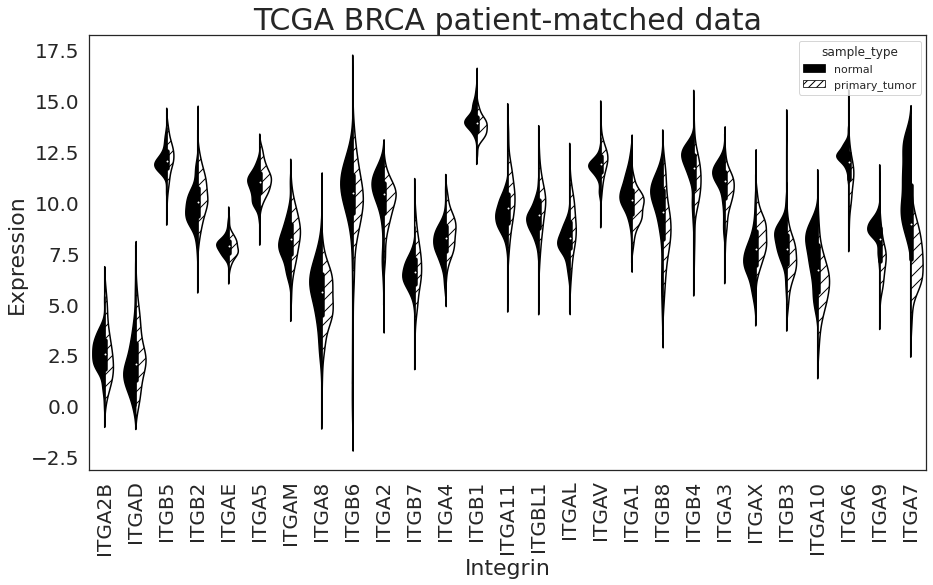

In [37]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set(style="white")
vplot=sns.violinplot(data=expr_for_vp,x="sample",y="value",hue='sample_type',ax=ax,
               split=True,palette=sns.color_palette(palette=['black','white']))
for i, violin in enumerate(vplot.findobj(mpl.collections.PolyCollection)):
    if i % 2:
        violin.set_hatch("//")

ax.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("///")
ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=90)
ax.tick_params(axis='y', labelsize=20)      
ax.set_xlabel('Integrin',fontsize=22)
ax.set_ylabel('Expression',fontsize=22)
#axes[j].set_ylim(-4,16)
ax.set_title('TCGA BRCA patient-matched data',fontsize=30)


# integrin expression molecular subtypes

In [88]:
tcga_brca_df_normal_matched

,TCGA-A7-A0CE-11,TCGA-A7-A0CH-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,...,TCGA-E9-A1NG-11,TCGA-E9-A1R7-11,TCGA-E9-A1RB-11,TCGA-E9-A1RC-11,TCGA-E9-A1RD-11,TCGA-E9-A1RF-11,TCGA-E9-A1RH-11,TCGA-E9-A1RI-11,TCGA-GI-A2C8-11,TCGA-GI-A2C9-11
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.9980,10.0819,9.5692,9.9530,10.0876,9.6265,10.3847,8.5990,9.5065,9.9090,...,10.1785,9.5149,9.4134,9.5920,9.8345,9.1559,9.4519,8.5599,11.4655,10.1605
HIF3A,6.1594,8.5517,9.3537,8.4743,8.4513,8.1546,8.2842,10.0837,8.6655,8.1872,...,7.8284,9.1886,7.8353,9.1444,8.4490,9.3591,9.1667,9.6765,7.1927,8.0760
RNF17,4.1813,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.8553,0.0000,1.4583,0.6975,1.3813,3.4103,0.0000,2.2077,2.6801
RNF10,11.7961,11.9788,11.9178,11.8456,11.7447,11.9869,11.7907,11.8645,11.6472,11.8263,...,11.8528,11.8201,11.8439,12.0187,11.8588,11.9110,11.8981,12.1180,13.3639,11.4906
RNF11,11.2214,11.5315,11.9225,11.5743,11.8232,11.9344,11.5187,12.2617,11.6499,11.5754,...,11.9259,12.2380,11.9400,12.2147,11.9001,12.2798,12.1746,13.0778,12.3311,11.5022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRF,13.7843,15.1120,15.6531,14.8932,14.4577,14.3703,14.3798,14.2898,13.9341,14.5242,...,15.3876,15.1685,14.4133,15.4023,15.1075,14.8809,14.7675,14.8309,13.0824,14.2220
BCL6B,8.0209,9.0868,9.4835,9.6457,8.3374,9.7785,9.6968,9.3801,8.9867,9.1906,...,9.3100,9.3268,8.1669,9.7527,9.5528,10.0796,9.1603,9.9381,9.1009,9.7099
GSTK1,11.8650,11.7615,11.3607,11.1019,11.0739,11.6932,11.4580,11.4126,11.1600,11.4123,...,11.2147,11.0763,10.9630,11.6692,11.4545,11.4236,11.3393,11.2866,11.5277,11.1542


In [91]:
#not patient matched
mol_subtype_sample_info=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal') & (tcga_brca_sample_info['PAM50Call_RNAseq'].notna())]
mol_subtype_index=mol_subtype_sample_info.index                                              
mol_subtype_index=mol_subtype_index.intersection(tcga_brca_df_primtum_matched.columns)
mol_subtype_list=mol_subtype_sample_info['PAM50Call_RNAseq'].unique()  
temp_mol_subtype_df=tcga_brca_df_primtum_matched[mol_subtype_index].copy()
temp_mol_subtype_df=temp_mol_subtype_df.loc[temp_mol_subtype_df.index.str.contains('ITG')]
itg_list=temp_mol_subtype_df.loc[temp_mol_subtype_df.index.str.contains('ITG')].index
temp_mol_subtype_df.loc['sample_type']=mol_subtype_sample_info.loc[mol_subtype_index]['sample_type']
temp_mol_subtype_df.loc['PAM50Call_RNAseq']=mol_subtype_sample_info.loc[mol_subtype_index]['PAM50Call_RNAseq']

temp_mol_subtype_df                                              


,TCGA-A7-A0CE-01,TCGA-A7-A0CH-01,TCGA-A7-A0D9-01,TCGA-A7-A0DB-01,TCGA-A7-A0DC-01,TCGA-A7-A13E-01,TCGA-A7-A13F-01,TCGA-A7-A13G-01,TCGA-AC-A23H-01,TCGA-AC-A2FB-01,...,TCGA-E9-A1NG-01,TCGA-E9-A1R7-01,TCGA-E9-A1RB-01,TCGA-E9-A1RC-01,TCGA-E9-A1RD-01,TCGA-E9-A1RF-01,TCGA-E9-A1RH-01,TCGA-E9-A1RI-01,TCGA-GI-A2C8-01,TCGA-GI-A2C9-01
sample,,,,,,,,,,,,,,,,,,,,,
ITGA8,4.166,4.5387,6.2466,5.1335,3.4288,2.3979,5.05,4.3861,4.4482,5.6141,...,5.1948,6.7066,3.5117,6.1536,6.9777,2.904,4.8536,7.1993,6.4376,6.1858
ITGA9,5.9704,7.247,6.2544,7.3697,5.8526,7.8421,6.9341,6.9474,5.8759,8.689,...,7.2161,6.9187,7.6001,6.9659,7.2161,5.9722,6.3273,6.7513,7.8067,6.4006
ITGA1,9.2606,8.5431,10.6367,9.0691,8.6499,8.8497,9.7749,8.7443,9.3518,9.6411,...,11.1967,9.8011,9.3416,9.062,9.7759,10.0805,9.0982,10.5632,10.3893,8.4378
ITGA2,11.5923,10.4154,10.6051,10.1341,10.2146,7.0959,10.179,10.2852,10.4412,10.3721,...,9.2577,10.8014,10.1714,10.2782,8.4422,9.6665,7.135,10.8585,8.6782,10.6084
ITGA3,11.198,10.4477,9.8658,10.7117,10.0499,8.6738,11.665,10.4315,11.214,11.135,...,11.3434,10.3561,9.0438,9.0977,10.6165,12.3264,10.632,11.3081,9.9117,10.3121
ITGA4,7.221,7.8774,7.5176,7.5635,6.114,7.6335,9.3076,7.052,7.5703,10.1321,...,9.7276,7.8759,8.0689,7.0321,8.1282,8.3911,7.9383,8.9484,9.1402,8.9391
ITGA5,10.4804,10.6071,11.3089,10.5396,10.6425,10.7939,11.4953,10.5376,11.6207,10.9994,...,12.5841,10.5812,10.6631,11.321,10.6918,11.7057,11.4882,11.1284,11.2187,10.4074
ITGA6,11.0381,11.3563,10.7394,11.4023,9.7697,10.6176,12.0176,11.8795,11.5613,11.0649,...,11.8745,10.487,9.1527,8.6215,12.1176,10.172,10.0895,11.1601,10.1698,13.0491
ITGA7,8.5673,5.9955,7.8931,8.9488,6.4941,7.3474,6.5072,7.024,4.3251,7.7887,...,6.1628,6.5797,5.3038,6.4191,6.8613,5.8916,3.5194,6.2824,8.2973,6.4289


In [89]:
normal_subtype_brca_df=tcga_brca_df_normal_matched.loc[tcga_brca_df_normal_matched.index.str.contains('ITG')].copy()
normal_subtype_brca_df.loc['sample_type']=np.repeat('Solid Tissue Normal',normal_subtype_brca_df.shape[1])
normal_subtype_brca_df.loc['PAM50Call_RNAseq']=np.repeat('Normal',normal_subtype_brca_df.shape[1])
normal_subtype_brca_df


,TCGA-A7-A0CE-11,TCGA-A7-A0CH-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,...,TCGA-E9-A1NG-11,TCGA-E9-A1R7-11,TCGA-E9-A1RB-11,TCGA-E9-A1RC-11,TCGA-E9-A1RD-11,TCGA-E9-A1RF-11,TCGA-E9-A1RH-11,TCGA-E9-A1RI-11,TCGA-GI-A2C8-11,TCGA-GI-A2C9-11
sample,,,,,,,,,,,,,,,,,,,,,
ITGA8,5.005,4.004,5.2543,6.7984,6.2484,6.8718,6.533,6.7157,5.8374,6.7754,...,5.5566,8.4797,7.5528,6.9749,5.2593,5.2899,6.2708,6.7294,7.0704,7.0314
ITGA9,7.8488,7.5911,9.0637,9.0951,8.8858,9.2256,8.7626,8.7208,8.868,8.7291,...,8.9414,9.0513,8.9035,9.2917,8.919,9.3079,8.9675,8.4542,8.4555,8.959
ITGA1,9.3449,9.9666,12.3343,11.3063,11.3591,11.8418,11.1567,11.443,10.3726,10.117,...,11.8337,11.9218,11.16,12.5261,11.7248,12.1279,11.1967,12.609,10.2595,10.114
ITGA2,10.5087,9.0078,6.9329,6.9078,10.0577,9.9696,10.2885,7.2155,11.2646,10.3288,...,9.8644,9.969,10.7057,7.2808,9.6216,7.3569,9.337,7.8681,6.1873,10.6897
ITGA3,12.1633,11.0629,9.2634,9.3083,10.7062,10.9384,11.0538,8.5761,11.2904,11.6602,...,10.7868,10.3271,10.2582,9.4435,10.8074,8.6318,10.21,8.5906,8.7591,11.4471
ITGA4,7.9454,7.8941,7.8031,7.1759,7.016,7.6718,7.7146,7.1903,8.3839,8.4795,...,7.9039,8.6368,8.9948,7.6137,8.0452,8.0815,7.5841,7.1808,5.6054,8.0351
ITGA5,10.893,11.3925,11.2717,12.1873,11.2167,11.4985,11.4212,10.9909,10.7951,11.3538,...,11.5639,11.1679,10.8724,11.2126,11.2323,11.4356,10.9779,10.5339,10.3838,11.5974
ITGA6,12.2042,11.6457,12.0232,11.3186,12.0884,12.1264,12.6044,11.8084,12.8452,12.3444,...,12.0724,12.5391,12.2459,12.2398,12.1756,12.2895,12.0553,12.3642,11.0866,12.6443
ITGA7,9.8722,12.6237,13.4746,12.8193,12.3028,12.7438,12.3338,13.075,8.8356,11.1425,...,12.7195,12.1716,11.9576,13.4362,12.9761,12.7824,13.1978,12.8085,13.2321,10.2412


In [90]:
combined_subtype_df=pd.concat([normal_subtype_brca_df,temp_mol_subtype_df],axis=1).copy()
combined_subtype_df

,TCGA-A7-A0CE-11,TCGA-A7-A0CH-11,TCGA-A7-A0D9-11,TCGA-A7-A0DB-11,TCGA-A7-A0DC-11,TCGA-A7-A13E-11,TCGA-A7-A13F-11,TCGA-A7-A13G-11,TCGA-AC-A23H-11,TCGA-AC-A2FB-11,...,TCGA-E9-A1NG-01,TCGA-E9-A1R7-01,TCGA-E9-A1RB-01,TCGA-E9-A1RC-01,TCGA-E9-A1RD-01,TCGA-E9-A1RF-01,TCGA-E9-A1RH-01,TCGA-E9-A1RI-01,TCGA-GI-A2C8-01,TCGA-GI-A2C9-01
sample,,,,,,,,,,,,,,,,,,,,,
ITGA8,5.005,4.004,5.2543,6.7984,6.2484,6.8718,6.533,6.7157,5.8374,6.7754,...,5.1948,6.7066,3.5117,6.1536,6.9777,2.904,4.8536,7.1993,6.4376,6.1858
ITGA9,7.8488,7.5911,9.0637,9.0951,8.8858,9.2256,8.7626,8.7208,8.868,8.7291,...,7.2161,6.9187,7.6001,6.9659,7.2161,5.9722,6.3273,6.7513,7.8067,6.4006
ITGA1,9.3449,9.9666,12.3343,11.3063,11.3591,11.8418,11.1567,11.443,10.3726,10.117,...,11.1967,9.8011,9.3416,9.062,9.7759,10.0805,9.0982,10.5632,10.3893,8.4378
ITGA2,10.5087,9.0078,6.9329,6.9078,10.0577,9.9696,10.2885,7.2155,11.2646,10.3288,...,9.2577,10.8014,10.1714,10.2782,8.4422,9.6665,7.135,10.8585,8.6782,10.6084
ITGA3,12.1633,11.0629,9.2634,9.3083,10.7062,10.9384,11.0538,8.5761,11.2904,11.6602,...,11.3434,10.3561,9.0438,9.0977,10.6165,12.3264,10.632,11.3081,9.9117,10.3121
ITGA4,7.9454,7.8941,7.8031,7.1759,7.016,7.6718,7.7146,7.1903,8.3839,8.4795,...,9.7276,7.8759,8.0689,7.0321,8.1282,8.3911,7.9383,8.9484,9.1402,8.9391
ITGA5,10.893,11.3925,11.2717,12.1873,11.2167,11.4985,11.4212,10.9909,10.7951,11.3538,...,12.5841,10.5812,10.6631,11.321,10.6918,11.7057,11.4882,11.1284,11.2187,10.4074
ITGA6,12.2042,11.6457,12.0232,11.3186,12.0884,12.1264,12.6044,11.8084,12.8452,12.3444,...,11.8745,10.487,9.1527,8.6215,12.1176,10.172,10.0895,11.1601,10.1698,13.0491
ITGA7,9.8722,12.6237,13.4746,12.8193,12.3028,12.7438,12.3338,13.075,8.8356,11.1425,...,6.1628,6.5797,5.3038,6.4191,6.8613,5.8916,3.5194,6.2824,8.2973,6.4289


In [92]:
expr_for_vp=pd.melt(combined_subtype_df.T,
                    id_vars=['sample_type']+['PAM50Call_RNAseq'],value_vars=list(itg_list))
expr_for_vp['sample_type']=expr_for_vp['sample_type'].astype(str)
expr_for_vp['PAM50Call_RNAseq']=expr_for_vp['PAM50Call_RNAseq'].astype(str)
expr_for_vp['value']=expr_for_vp['value'].astype('float64')
expr_for_vp


,sample_type,PAM50Call_RNAseq,sample,value
0,Solid Tissue Normal,Normal,ITGA8,5.0050
1,Solid Tissue Normal,Normal,ITGA8,4.0040
2,Solid Tissue Normal,Normal,ITGA8,5.2543
3,Solid Tissue Normal,Normal,ITGA8,6.7984
4,Solid Tissue Normal,Normal,ITGA8,6.2484
...,...,...,...,...
5908,Primary Tumor,LumA,ITGB2,10.9485
5909,Primary Tumor,Her2,ITGB2,10.2843
5910,Primary Tumor,LumA,ITGB2,10.1356
5911,Primary Tumor,LumA,ITGB2,11.1859


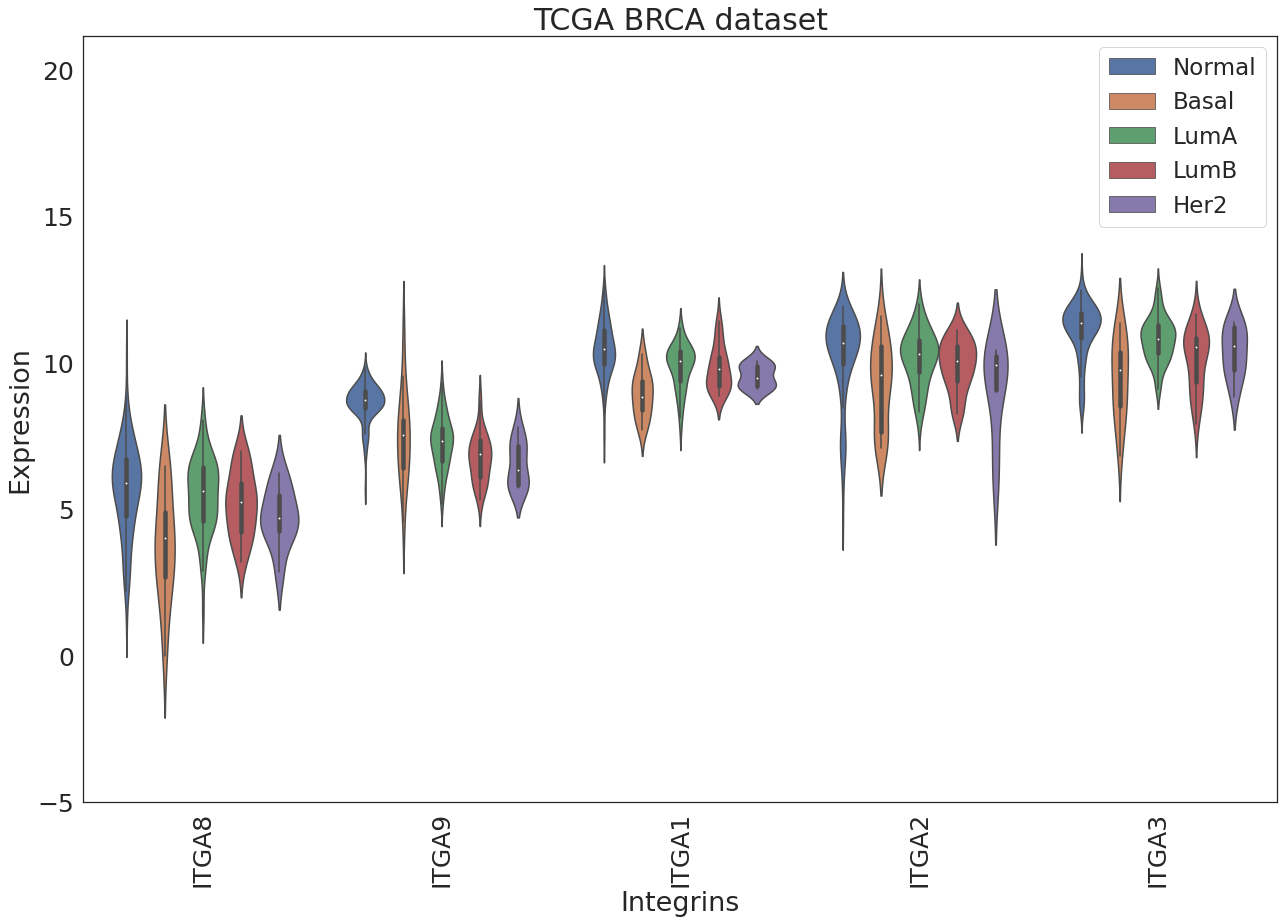

In [113]:
#mostly patient matched 

fig,axes=plt.subplots(figsize=(18,13))

j=0
sns.set(style="white")
min_lim_expr=expr_for_vp['value'].min()
max_lim_expr=expr_for_vp['value'].max()

ax=sns.violinplot(data=expr_for_vp[expr_for_vp['sample'].isin(itg_list[0:5])],
                  x="sample",y="value",hue='PAM50Call_RNAseq',ax=axes)
# for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     if i % 2:
#         violin.set_hatch("//")
axes.legend(fontsize=23)
# axes.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("///")        

ax.set_xticklabels(ax.get_xticklabels(),fontsize=25,rotation=90)
ax.tick_params(axis='y', labelsize=25)      
axes.set_xlabel('Integrins',fontsize=27)
axes.set_ylabel('Expression',fontsize=27)

axes.set_ylim(min_lim_expr-5,max_lim_expr+5)
axes.set_title('TCGA BRCA dataset',fontsize=30)
j+=1

plt.tight_layout()



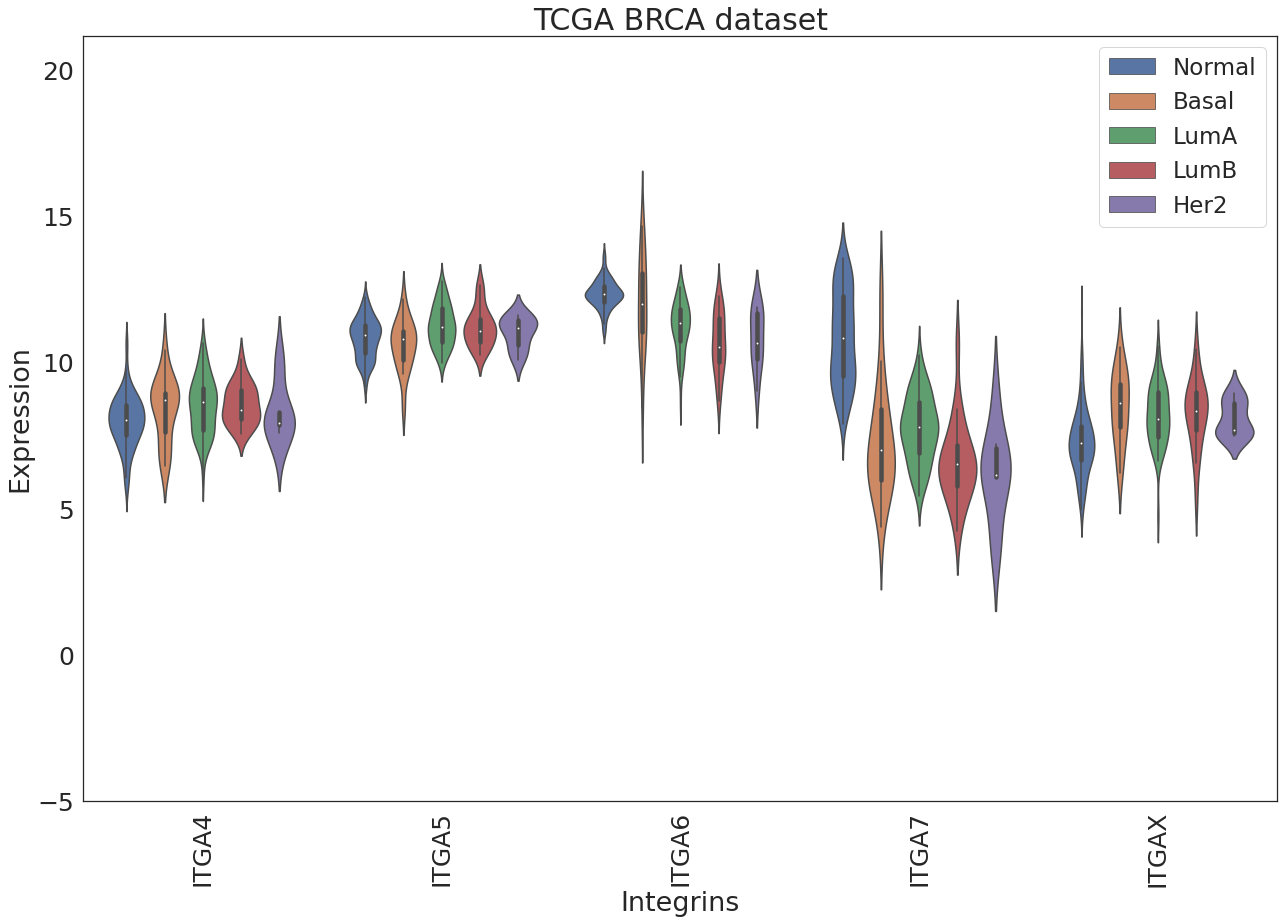

In [114]:
#mostly patient matched 

fig,axes=plt.subplots(figsize=(18,13))

j=0
sns.set(style="white")
min_lim_expr=expr_for_vp['value'].min()
max_lim_expr=expr_for_vp['value'].max()

ax=sns.violinplot(data=expr_for_vp[expr_for_vp['sample'].isin(itg_list[5:10])],
                  x="sample",y="value",hue='PAM50Call_RNAseq',ax=axes)
# for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     if i % 2:
#         violin.set_hatch("//")
axes.legend(fontsize=23)
# axes.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("///")        

ax.set_xticklabels(ax.get_xticklabels(),fontsize=25,rotation=90)
ax.tick_params(axis='y', labelsize=25)      
axes.set_xlabel('Integrins',fontsize=27)
axes.set_ylabel('Expression',fontsize=27)

axes.set_ylim(min_lim_expr-5,max_lim_expr+5)
axes.set_title('TCGA BRCA dataset',fontsize=30)
j+=1

plt.tight_layout()



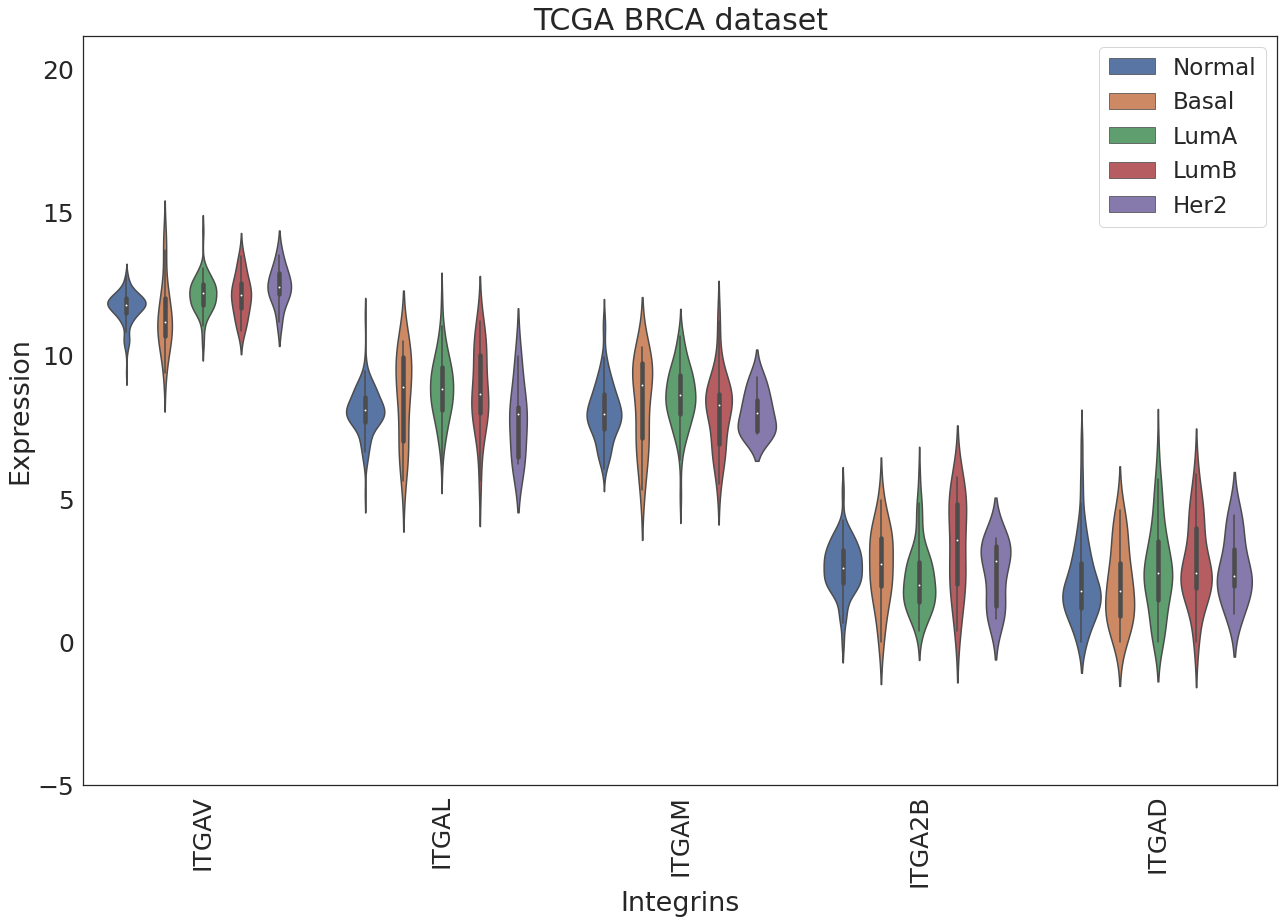

In [115]:
#mostly patient matched 

fig,axes=plt.subplots(figsize=(18,13))

j=0
sns.set(style="white")
min_lim_expr=expr_for_vp['value'].min()
max_lim_expr=expr_for_vp['value'].max()

ax=sns.violinplot(data=expr_for_vp[expr_for_vp['sample'].isin(itg_list[10:15])],
                  x="sample",y="value",hue='PAM50Call_RNAseq',ax=axes)
# for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     if i % 2:
#         violin.set_hatch("//")
axes.legend(fontsize=23)
# axes.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("///")        

ax.set_xticklabels(ax.get_xticklabels(),fontsize=25,rotation=90)
ax.tick_params(axis='y', labelsize=25)      
axes.set_xlabel('Integrins',fontsize=27)
axes.set_ylabel('Expression',fontsize=27)

axes.set_ylim(min_lim_expr-5,max_lim_expr+5)
axes.set_title('TCGA BRCA dataset',fontsize=30)
j+=1

plt.tight_layout()



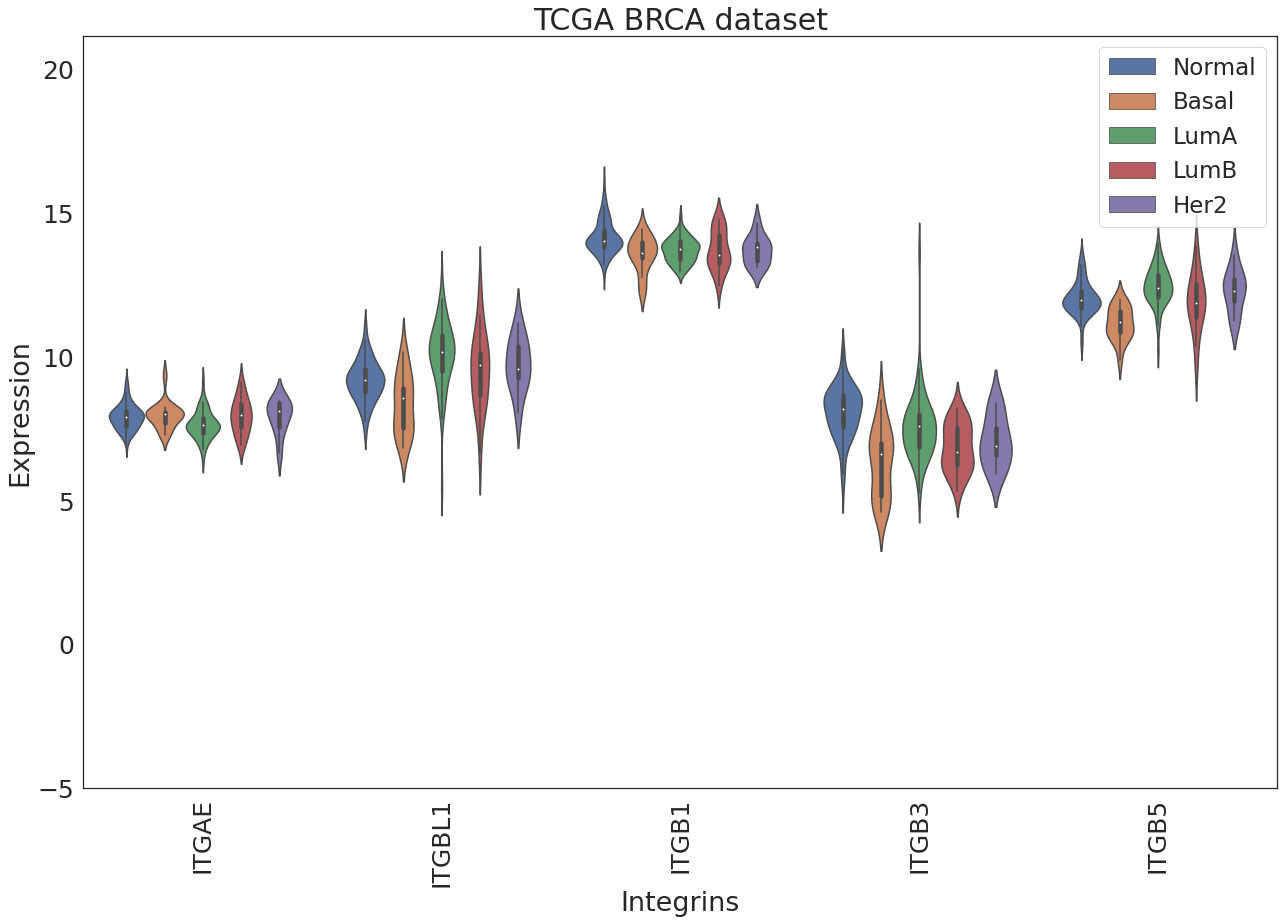

In [116]:
#mostly patient matched 

fig,axes=plt.subplots(figsize=(18,13))

j=0
sns.set(style="white")
min_lim_expr=expr_for_vp['value'].min()
max_lim_expr=expr_for_vp['value'].max()

ax=sns.violinplot(data=expr_for_vp[expr_for_vp['sample'].isin(itg_list[15:20])],
                  x="sample",y="value",hue='PAM50Call_RNAseq',ax=axes)
# for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     if i % 2:
#         violin.set_hatch("//")
axes.legend(fontsize=23)
# axes.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("///")        

ax.set_xticklabels(ax.get_xticklabels(),fontsize=25,rotation=90)
ax.tick_params(axis='y', labelsize=25)      
axes.set_xlabel('Integrins',fontsize=27)
axes.set_ylabel('Expression',fontsize=27)

axes.set_ylim(min_lim_expr-5,max_lim_expr+5)
axes.set_title('TCGA BRCA dataset',fontsize=30)
j+=1

plt.tight_layout()



In [160]:
expr_for_vp['PAM50Call_RNAseq'].value_counts()

Normal    2997
LumA      1647
LumB       567
Basal      459
Her2       243
Name: PAM50Call_RNAseq, dtype: int64

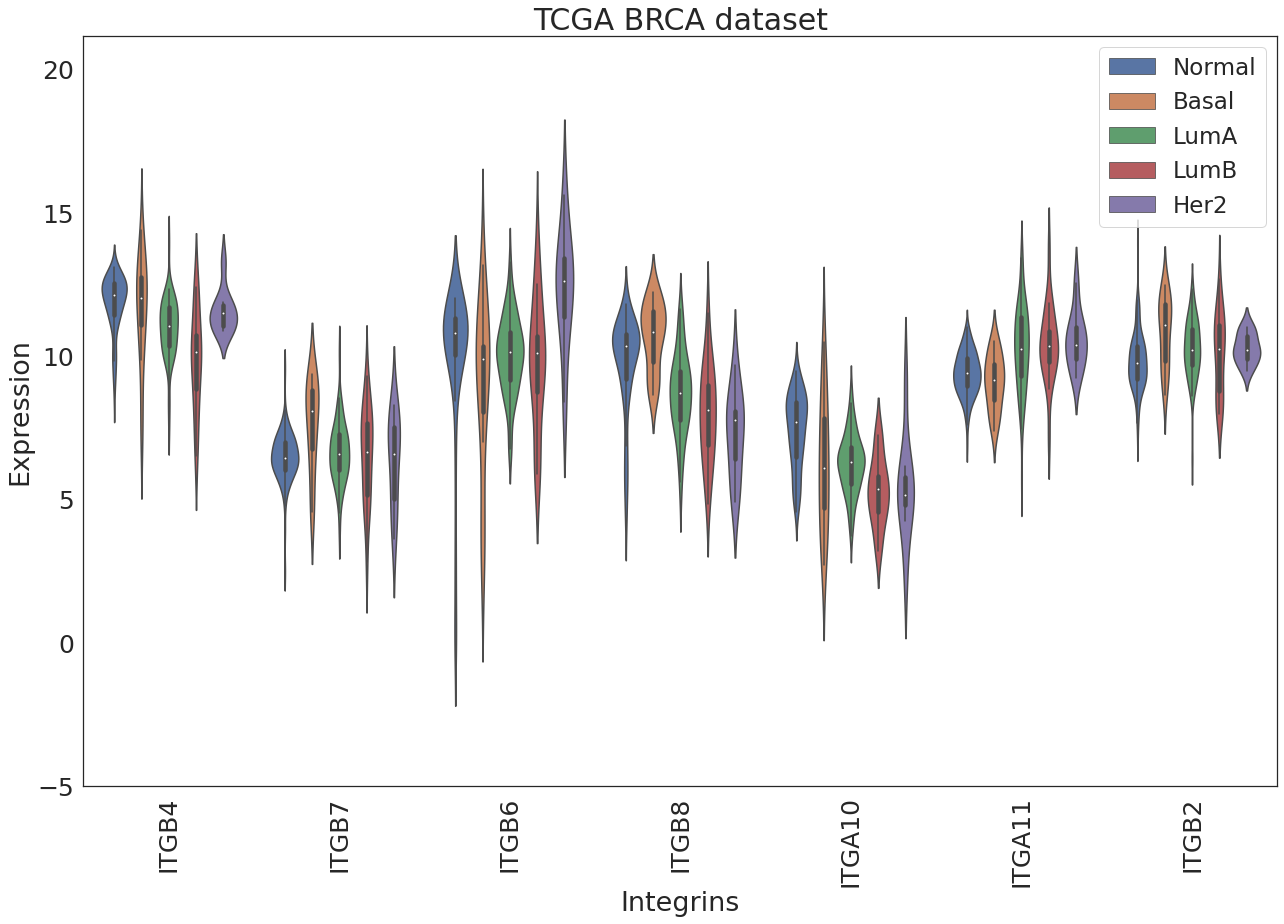

In [117]:
#mostly patient matched 

fig,axes=plt.subplots(figsize=(18,13))

j=0
sns.set(style="white")
min_lim_expr=expr_for_vp['value'].min()
max_lim_expr=expr_for_vp['value'].max()

ax=sns.violinplot(data=expr_for_vp[expr_for_vp['sample'].isin(itg_list[20:])],
                  x="sample",y="value",hue='PAM50Call_RNAseq',ax=axes)
# for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
#     if i % 2:
#         violin.set_hatch("//")
axes.legend(fontsize=23)
# axes.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("///")        

ax.set_xticklabels(ax.get_xticklabels(),fontsize=25,rotation=90)
ax.tick_params(axis='y', labelsize=25)      
axes.set_xlabel('Integrins',fontsize=27)
axes.set_ylabel('Expression',fontsize=27)

axes.set_ylim(min_lim_expr-5,max_lim_expr+5)
axes.set_title('TCGA BRCA dataset',fontsize=30)
j+=1

plt.tight_layout()



/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



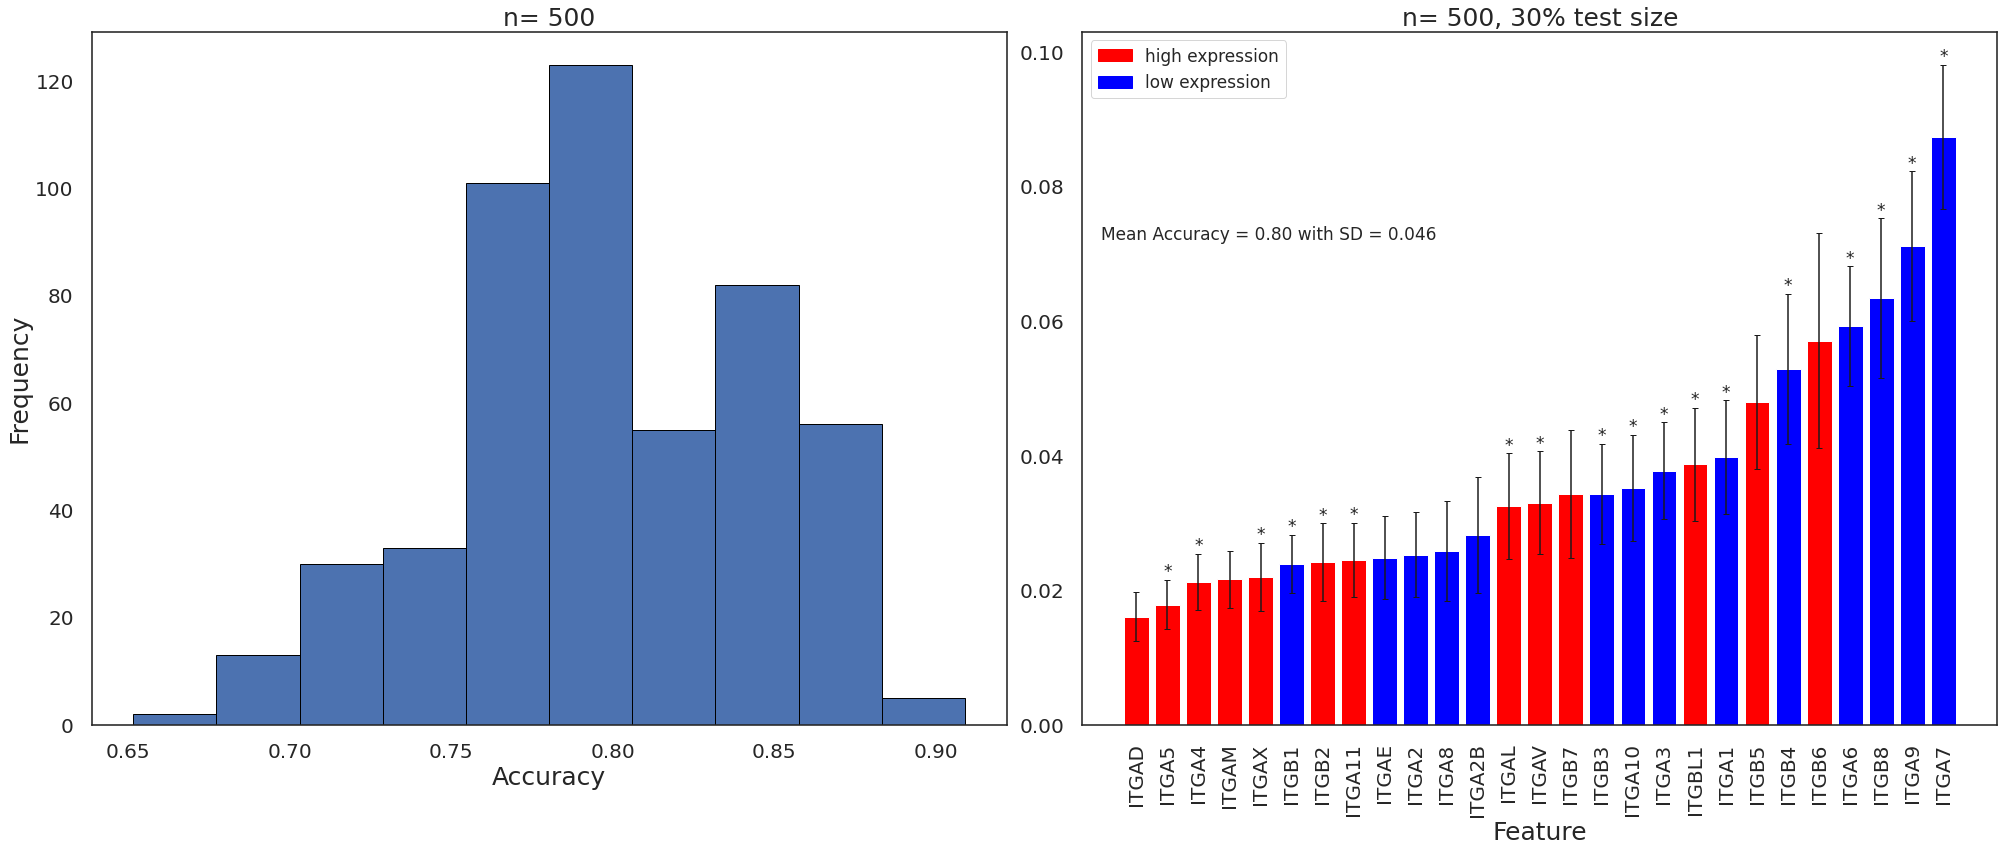

In [161]:

#class weight balanced here
fig, ax = plt.subplots(1,2, figsize=(28, 12))
n=500
feature_importance=[]
accuracy=[]
test_size=0.30
auc_roc=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = combined_subtype_df.loc[combined_subtype_df.index[combined_subtype_df.index.str.contains("ITG")]].T
    y = combined_subtype_df.loc["PAM50Call_RNAseq"]
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test),multi_class='ovo'))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3,
                                    color=feature_importance_df_mean.bar_color)
for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
    if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
        ax[1].annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
                   size=17, xytext=(0, 8),
                   textcoords='offset points')

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f'{i} expression' for i in colors]
plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
# ax[1].text(0.02,
#            0.7,
# f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}',
#            transform=ax[1].transAxes,fontsize=17)

ax[1].text(0.02,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)


#ax[0].remove()
plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')


/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



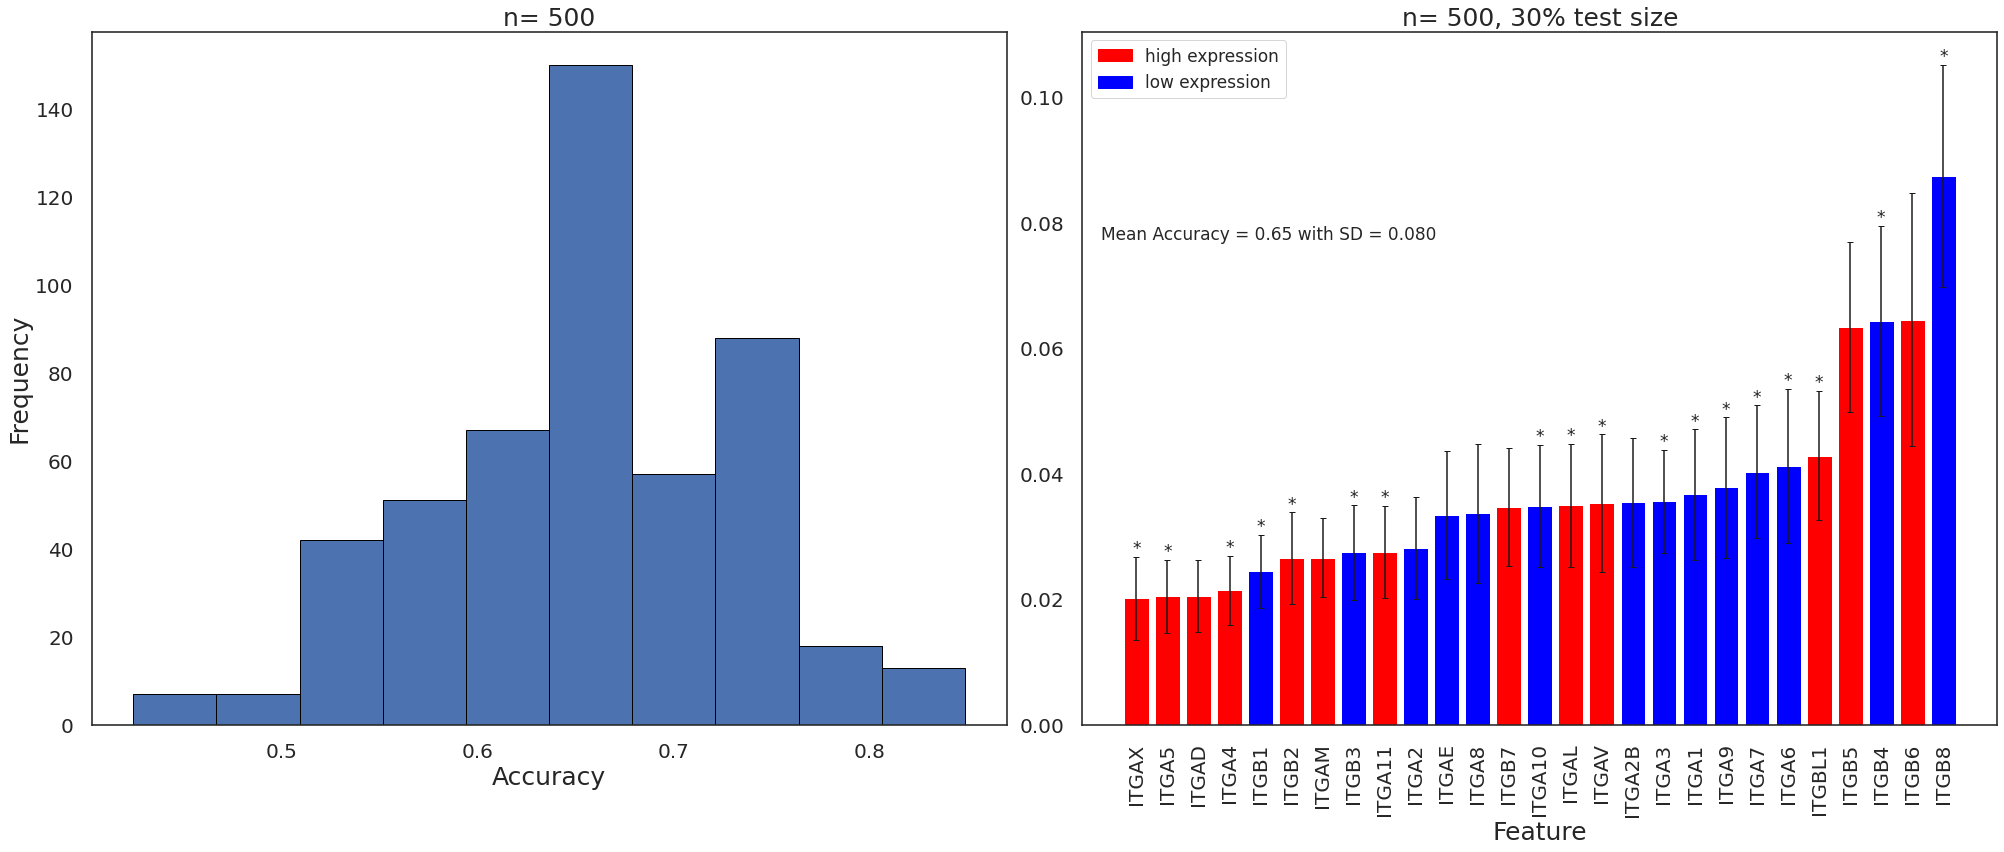

In [154]:

#class weight balanced here
fig, ax = plt.subplots(1,2, figsize=(28, 12))
n=500
feature_importance=[]
accuracy=[]
test_size=0.30
auc_roc=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_mol_subtype_df.loc[temp_mol_subtype_df.index[temp_mol_subtype_df.index.str.contains("ITG")]].T
    y = temp_mol_subtype_df.loc["PAM50Call_RNAseq"]
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test),multi_class='ovo'))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3,
                                    color=feature_importance_df_mean.bar_color)
for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
    if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
        ax[1].annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
                   size=17, xytext=(0, 8),
                   textcoords='offset points')

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f'{i} expression' for i in colors]
plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
# ax[1].text(0.02,
#            0.7,
# f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}',
#            transform=ax[1].transAxes,fontsize=17)
ax[1].text(0.02,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)


#ax[0].remove()
plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')


/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



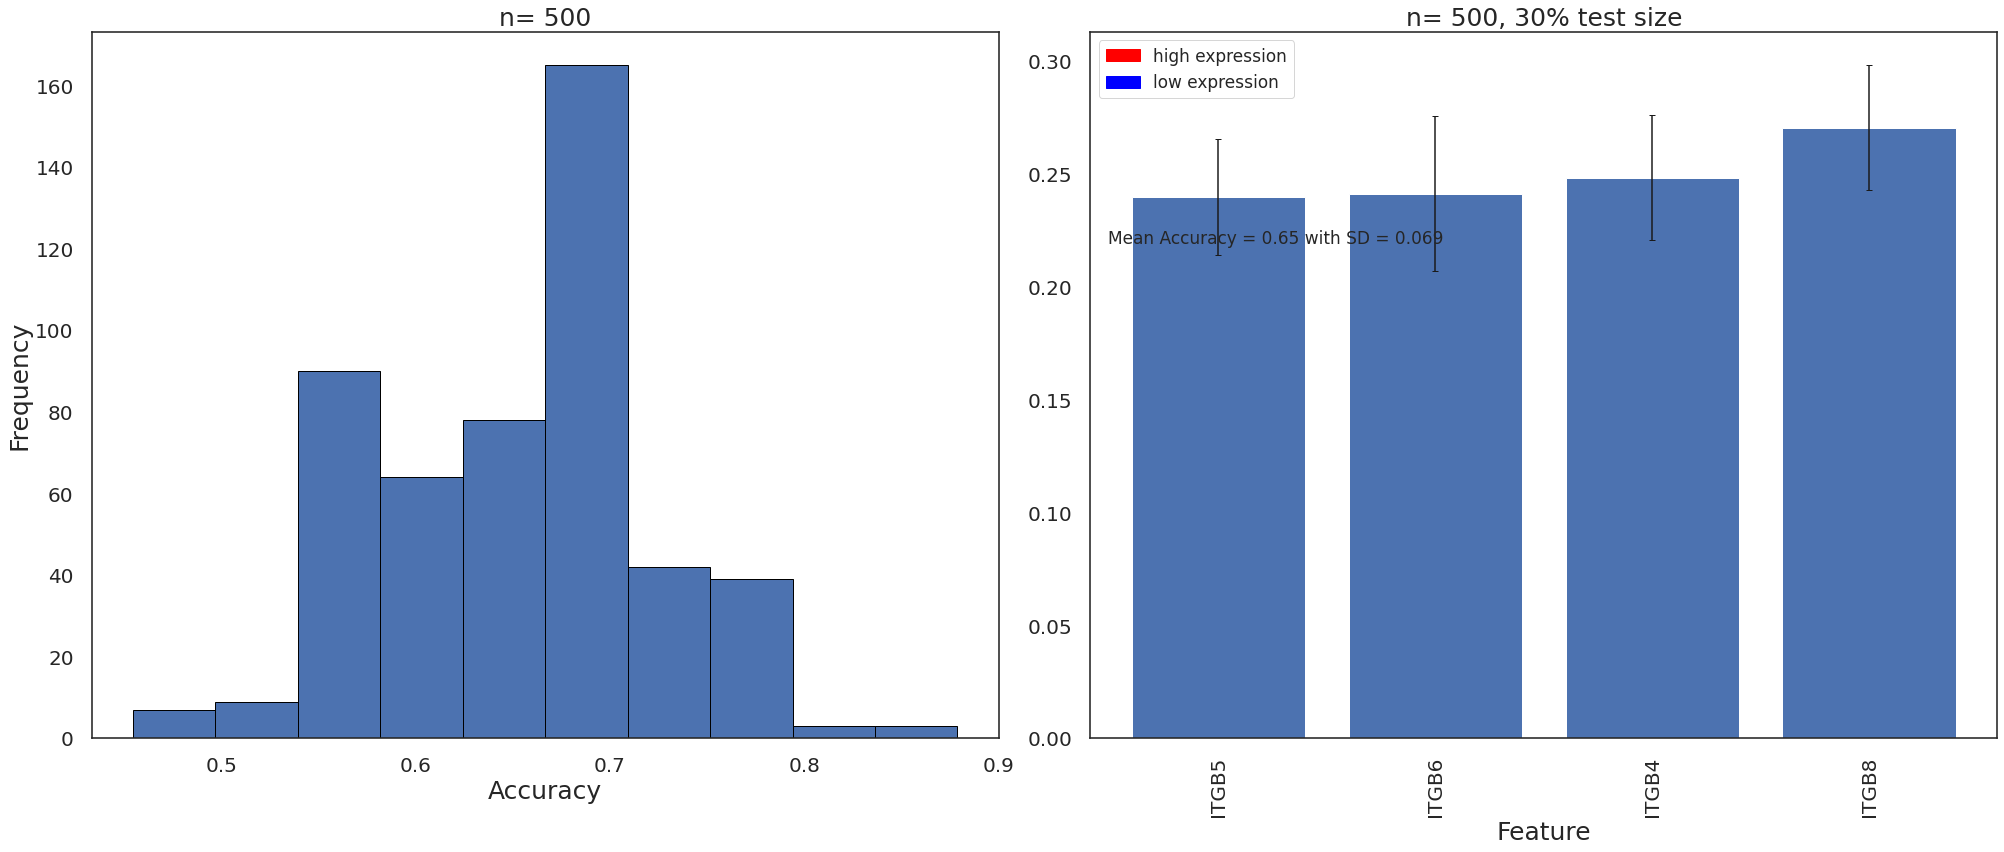

In [166]:

#class weight balanced here
fig, ax = plt.subplots(1,2, figsize=(28, 12))
top_integrins=['ITGB8','ITGB6','ITGB4','ITGB5']
n=500
feature_importance=[]
accuracy=[]
test_size=0.30
auc_roc=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_mol_subtype_df.loc[temp_mol_subtype_df.index[temp_mol_subtype_df.index.isin(top_integrins)]].T
    y = temp_mol_subtype_df.loc["PAM50Call_RNAseq"]
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test),multi_class='ovo'))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
#feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
# colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

bars=ax[1].bar(feature_importance_df_mean.index,
     feature_importance_df_mean['importance'],
                                 yerr=feature_importance_df_err['importance'].values,
                                 capsize=3)
# for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
#     if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
#         ax[1].annotate('*',
#                    (bar.get_x() + bar.get_width()/2,
#                     bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
#                    size=17, xytext=(0, 8),
#                    textcoords='offset points')

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f'{i} expression' for i in colors]
plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
# ax[1].text(0.02,
#            0.7,
# f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}',
#            transform=ax[1].transAxes,fontsize=17)
ax[1].text(0.02,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)


#ax[0].remove()
plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')


In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

x = temp_mol_subtype_df.loc[temp_mol_subtype_df.index[temp_mol_subtype_df.index.str.contains("ITG")]].T
y = temp_mol_subtype_df.loc["PAM50Call_RNAseq"]

data = list(zip(x, y))


linkage_data = linkage(data, method='average', metric='euclidean')
dendrogram(linkage_data)

plt.show()


ValueError: could not convert string to float: 'ITGA8'

In [173]:
x

sample,ITGA8,ITGA9,ITGA1,ITGA2,ITGA3,ITGA4,ITGA5,ITGA6,ITGA7,ITGAX,...,ITGB1,ITGB3,ITGB5,ITGB4,ITGB7,ITGB6,ITGB8,ITGA10,ITGA11,ITGB2
TCGA-A7-A0CE-01,4.166,5.9704,9.2606,11.5923,11.198,7.221,10.4804,11.0381,8.5673,7.589,...,13.6028,6.947,11.351,12.4138,6.7521,9.3036,10.5738,6.0165,9.7334,9.4471
TCGA-A7-A0CH-01,4.5387,7.247,8.5431,10.4154,10.4477,7.8774,10.6071,11.3563,5.9955,7.7046,...,13.4336,6.7703,12.1693,11.4051,5.0936,11.1858,11.647,5.4218,11.0747,10.1289
TCGA-A7-A0D9-01,6.2466,6.2544,10.6367,10.6051,9.8658,7.5176,11.3089,10.7394,7.8931,6.9601,...,13.509,6.7609,13.9559,11.0158,4.538,6.7444,8.337,5.0493,10.0197,8.606
TCGA-A7-A0DB-01,5.1335,7.3697,9.0691,10.1341,10.7117,7.5635,10.5396,11.4023,8.9488,9.8578,...,13.725,6.881,13.3002,10.9226,5.9702,9.6389,7.3359,6.2353,11.1158,12.2299
TCGA-A7-A0DC-01,3.4288,5.8526,8.6499,10.2146,10.0499,6.114,10.6425,9.7697,6.4941,4.7522,...,13.093,6.9792,11.2383,7.4935,5.5101,6.8439,6.7852,5.2456,5.7251,6.4189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E9-A1RF-01,2.904,5.9722,10.0805,9.6665,12.3264,8.3911,11.7057,10.172,5.8916,9.1011,...,13.7319,6.8065,12.503,11.7228,7.0819,10.9654,6.3913,5.7247,11.6522,10.9485
TCGA-E9-A1RH-01,4.8536,6.3273,9.0982,7.135,10.632,7.9383,11.4882,10.0895,3.5194,7.491,...,13.9242,8.4083,12.6514,11.1184,7.6429,10.8192,4.9306,2.4438,10.3325,10.2843
TCGA-E9-A1RI-01,7.1993,6.7513,10.5632,10.8585,11.3081,8.9484,11.1284,11.1601,6.2824,8.9767,...,14.1391,7.66,12.7894,10.7733,5.8715,10.7377,9.0407,7.0215,11.93,10.1356
TCGA-GI-A2C8-01,6.4376,7.8067,10.3893,8.6782,9.9117,9.1402,11.2187,10.1698,8.2973,9.2663,...,13.5169,9.0511,12.2545,8.5539,6.4487,11.641,5.6204,6.1487,11.7825,11.1859


# hormone receptor status



In [186]:
tcga_brca_sample_info.loc[temp_samples]['horm_recep_status'].value_counts()

receptor_positive    514
triple_negative      120
triple_positive       54
receptor_negative     11
Name: horm_recep_status, dtype: int64

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



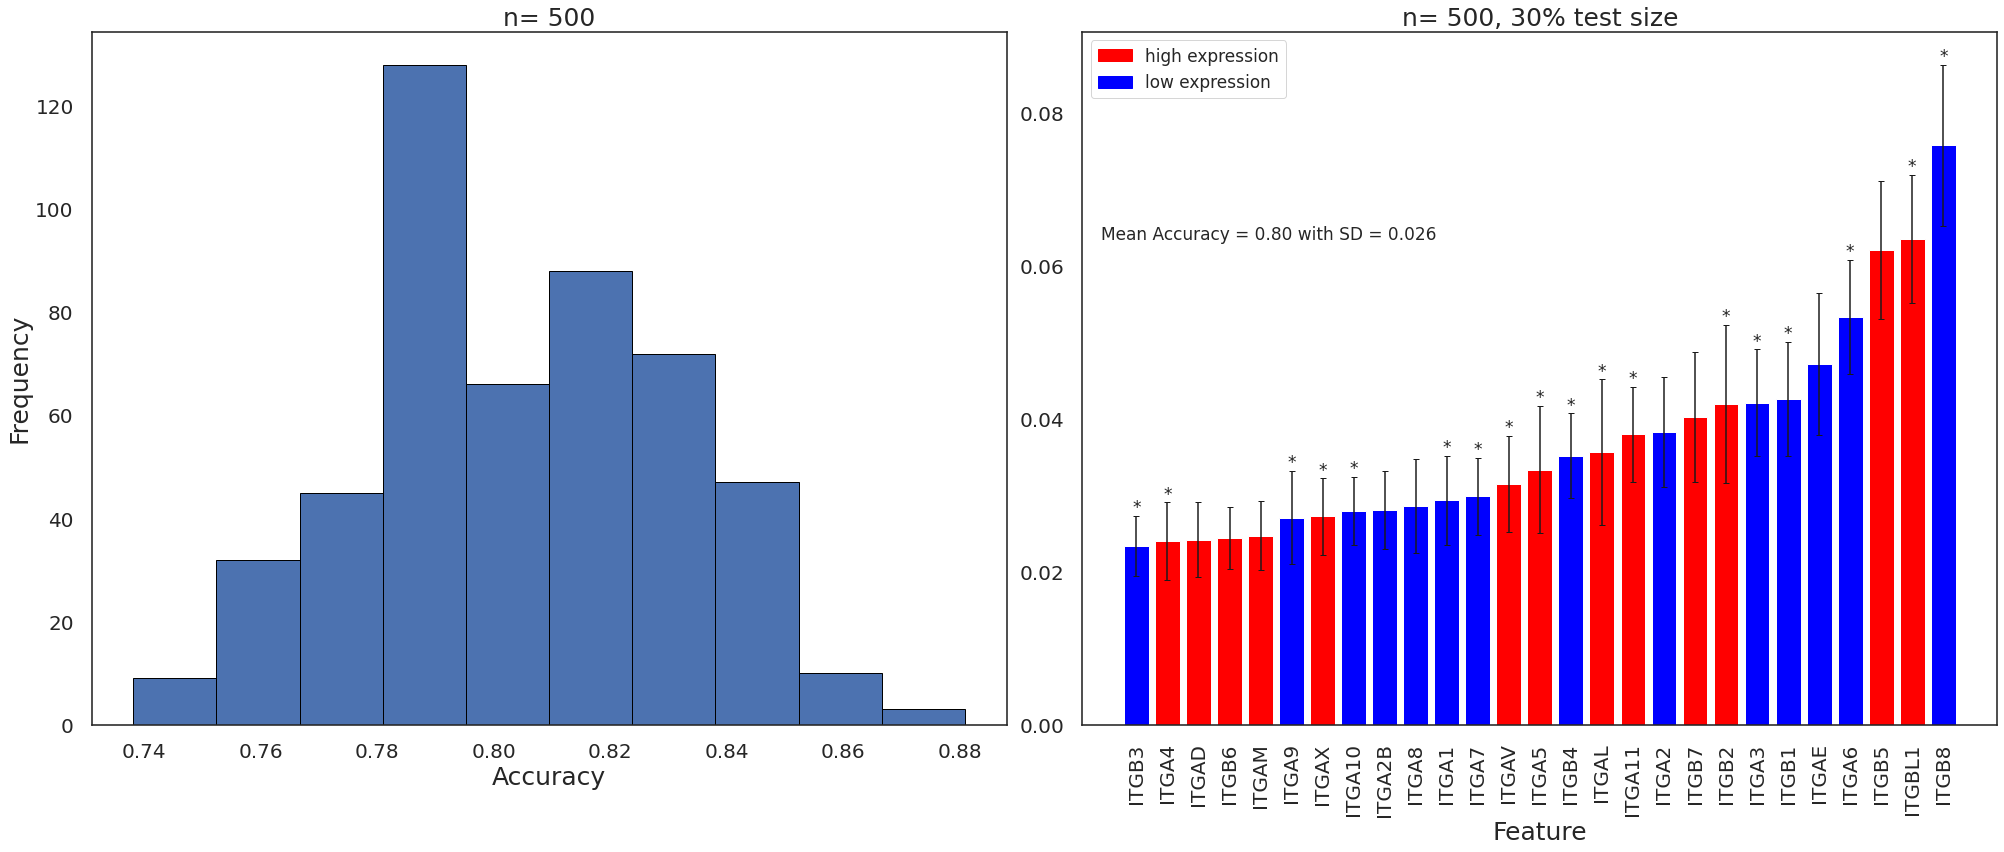

In [181]:
temp_samples=tcga_brca_sample_info[(tcga_brca_sample_info['sample_type']!='Solid Tissue Normal')&(tcga_brca_sample_info['PAM50Call_RNAseq']!='Normal')&(tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Indeterminate' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'nan' not in x)) & (tcga_brca_sample_info["ER_HER2_PR_combined_status"].apply(lambda x: 'Equivocal' not in x)) ].index
temp_tcga_brca_df = tcga_brca_df[temp_samples].copy()

#class weight balanced here
fig, ax = plt.subplots(1,2, figsize=(28, 12))
n=500
feature_importance=[]
accuracy=[]
test_size=0.30
auc_roc=[]
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_tcga_brca_df.loc[temp_tcga_brca_df.index[temp_tcga_brca_df.index.str.contains("ITG")]].T
    y = tcga_brca_sample_info.loc[temp_samples].loc[data.index]['horm_recep_status']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #auc_roc.append(roc_auc_score(y_test,classifier.predict_proba(X_test),multi_class='ovo'))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0],legend=False)
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_mean=pd.concat([feature_importance_df_mean,itg_expr_df],axis=1)
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
colors = feature_importance_df_mean.groupby('relative_expression')['bar_color'].apply(lambda x: list(x.unique())[0]).to_dict()

bars=ax[1].bar(feature_importance_df_mean.index,
    feature_importance_df_mean['importance'],
                                yerr=feature_importance_df_err['importance'].values,
                                capsize=3,
                                    color=feature_importance_df_mean.bar_color)
for bar,integrin in zip(bars.patches,feature_importance_df_mean.index):
    if feature_importance_df_mean.loc[integrin]['adj_significant_bonf']=='yes':
        ax[1].annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()+feature_importance_df_err.loc[integrin]['importance']), ha='center', va='center',
                   size=17, xytext=(0, 8),
                   textcoords='offset points')

ax[1].set_title(f"n= {n}, {int(test_size*100)}% test size",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12,rotation=90)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
#ax[1].legend(feature_importance_df_mean.relative_expression.unique(),fontsize=17)
handles = [mpatches.Patch(color=colors[i]) for i in colors]
labels = [f'{i} expression' for i in colors]
plt.legend(handles, labels,fontsize=17)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    
# ax[1].text(0.02,
#            0.7,
# f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}\nMean AUC = {format(np.mean(np.array(auc_roc)),"0.2f")} with SD = {format(np.std(np.array(auc_roc)),"0.3f")}',
#            transform=ax[1].transAxes,fontsize=17)
ax[1].text(0.02,
           0.7,
f'Mean Accuracy = {format(np.mean(np.array(accuracy)),"0.2f")} with SD = {format(np.std(np.array(accuracy)),"0.3f")}',
           transform=ax[1].transAxes,fontsize=17)


#ax[0].remove()
plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')




In [151]:
y.value_counts()

LumA     61
LumB     21
Basal    17
Her2      9
Name: PAM50Call_RNAseq, dtype: int64